In [268]:
# Data Manipulation and Handling
import polars as pl
import pandas as pd
import numpy as np
import psycopg2

# DB Credentials
from dotenv import load_dotenv
import os
import sys
from sqlalchemy import create_engine

# Machine Learning Libraries
import torch
import xgboost as xgb
import lightgbm as lgb
# from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, chi2, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_curve
import scipy.optimize as tnc
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Gradient Boosting Libraries
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model Lifecycle Management
import mlflow
import mlflow.sklearn

# Distributed Computing
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier as SparkRFClassifier

# Model Interpretability
import shap

# Hyperparameter Optimization
import optuna

# Automated Feature Engineering
import featuretools as ft

# Add parent directory to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Custom Modules
from fetch_data_hook import fetch_sql_code, fetch_sql_file
'''
SQL-like Functions in Pandas: https://towardsdatascience.com/sql-window-functions-in-python-pandas-data-science-dc7c7a63cbb4
'''

'\nSQL-like Functions in Pandas: https://towardsdatascience.com/sql-window-functions-in-python-pandas-data-science-dc7c7a63cbb4\n'

In [269]:
equity_df = fetch_sql_code('''select * from equity_value_data''')
equity_df.head(10)

timestamp  close_equity                           user_id
0 2016-10-03       27.2775  f5fc78a6931c205931827765e5b853f8
1 2016-10-04       24.9530  f5fc78a6931c205931827765e5b853f8
2 2016-10-05       27.5455  f5fc78a6931c205931827765e5b853f8
3 2016-10-06       26.8200  f5fc78a6931c205931827765e5b853f8
4 2016-10-07       25.9181  f5fc78a6931c205931827765e5b853f8
5 2016-10-10       26.2965  f5fc78a6931c205931827765e5b853f8
6 2016-10-11       25.3980  f5fc78a6931c205931827765e5b853f8
7 2016-10-12       24.6895  f5fc78a6931c205931827765e5b853f8
8 2016-10-13       28.1303  f5fc78a6931c205931827765e5b853f8
9 2016-10-14       28.0159  f5fc78a6931c205931827765e5b853f8

### Equity Volatility (Standard Deviation of Equity)

In [270]:
'''
- Why it's useful:
Volatility is a key measure in finance, as it represents the risk or stability of a user’s portfolio over time.
High volatility could indicate speculative behavior, which might correlate with churn or certain types of investment
activity.
- How to calculate:
1sd = 68% of the time the spread of the data is between + or - (mean +/- 1*sd value)
2sd = 95% of the time the spread of the data is between + or - (mean +/- 2*sd value)
3sd = 99.7% of the time the spread of the data is between + or - (mean +/- 3*sd value)
'''
# This assumes that each user has 2+ rows of data in equity_df.
new_df = equity_df.groupby('user_id')['close_equity'].std().reset_index()
new_df.columns = ['user_id', 'equity_volatility']
new_df

user_id  equity_volatility
0     0012db34aa7b083f5714e7831195e54d         191.975127
1     001d6c77dbdb3213cead7673f250bfdc         449.330147
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472
3     00384fa9be6fdca1b786bae70d78f88f          24.522490
4     0042aac295a0d4df88f4b83012778bd4         933.690027
...                                ...                ...
5579  ff9ee08791e20724a86995ab2bc72578          47.137114
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485
5581  ffae713096867a32e74f633060667153           7.194193
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605

[5584 rows x 2 columns]

In [271]:
new_df.isnull().sum()

user_id              0
equity_volatility    4
dtype: int64

In [272]:
null_rows = new_df[new_df.isnull().any(axis=1)]
null_rows

user_id  equity_volatility
1452  43104bbb1d5108f25d6bbc711c0c5dff                NaN
2223  66ae1899849dde0a7fef17b733daffe5                NaN
4179  c0fd72037e872e9871e9be2c1a938874                NaN
5484  fba346182e2d09b2d6fd2fb1e416ae90                NaN

In [273]:
null_users = null_rows['user_id'].tolist()
null_users

['43104bbb1d5108f25d6bbc711c0c5dff',
 '66ae1899849dde0a7fef17b733daffe5',
 'c0fd72037e872e9871e9be2c1a938874',
 'fba346182e2d09b2d6fd2fb1e416ae90']

In [274]:
equity_df[equity_df['user_id'].isin(null_users)]

timestamp  close_equity                           user_id
202752  2017-08-17        251.94  c0fd72037e872e9871e9be2c1a938874
875414  2017-01-18         10.64  fba346182e2d09b2d6fd2fb1e416ae90
878917  2017-02-09         10.00  43104bbb1d5108f25d6bbc711c0c5dff
1006123 2017-03-15         10.10  66ae1899849dde0a7fef17b733daffe5

In [275]:
new_df['equity_volatility'].fillna(0, inplace=True)
new_df.isnull().sum()

user_id              0
equity_volatility    0
dtype: int64

### Avg/SD aka 'volatility' Rolling 5 Day Average Equity

In [276]:
'''
- Why it's useful:
A rolling average smooths out short-term fluctuations in the equity value and highlights longer-term trends.
This feature can capture the general trajectory of a user’s equity over time.
- How to calculate:
Apply a rolling average over a window of time
'''
window_size = 5
equity_df[f'rolling_avg_equity_{window_size}d'] = equity_df.sort_values(by='timestamp', ascending=True)\
                                        .groupby('user_id')['close_equity']\
                                        .rolling(window=window_size).mean()\
                                        .reset_index(level=0, drop=True)

equity_df[f'rolling_sum_equity_{window_size}d'] = equity_df.sort_values(by='timestamp', ascending=True)\
                                        .groupby('user_id')['close_equity']\
                                        .rolling(window=window_size).sum()\
                                        .reset_index(level=0, drop=True)

# # aggregated_df = equity_df.groupby('user_id')['rolling_avg_equity_7d'].agg(['mean', 'sum', 'max', 'min', 'std']).reset_index()
# aggregated_df = equity_df.groupby('user_id')['close_equity'].rolling(window=7).std().reset_index(level=0, drop=True)

'''
We are interested in capturing long-term trends and smoothing out short-term fluctuations (rolling averages and sums over time), forward filling (ffill) seems to be the most appropriate choice.
Forward-filling ensures that missing data points in the early stages of a rolling window are filled with the most recent valid data, which is often a reasonable assumption when dealing
with time-series data such as user equity trajectories.  It also avoids the distortions that could arise from filling with zero or the mean.
'''
equity_df[f'rolling_avg_equity_{window_size}d'].fillna(method='ffill', inplace=True)
equity_df[f'rolling_sum_equity_{window_size}d'].fillna(method='ffill', inplace=True)

aggregated_df = equity_df.groupby('user_id').agg(
    # name_of_col_output=('column_name_being_agg', 'stat_method')
    avg_rolling_5day_avg=(f'rolling_avg_equity_{window_size}d', 'mean'),
    # remember std assumes you have 2 rows per user. If not - you will get a null
    sd_rolling_5day_avg=(f'rolling_avg_equity_{window_size}d', 'std'),
    avg_rolling_5day_sum=(f'rolling_sum_equity_{window_size}d', 'mean'),
    sd_rolling_5day_sum=(f'rolling_sum_equity_{window_size}d', 'std')
).reset_index()
aggregated_df
# remember std assumes you have 2 rows per user. If not - you will get a null
new_df = new_df.merge(aggregated_df, on='user_id', how='left')
new_df['sd_rolling_5day_avg'].fillna(0, inplace=True)
new_df['sd_rolling_5day_sum'].fillna(0, inplace=True)
new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  
0              978.965713  
1             2804.337036  
2             1626.512702  
3            17883.482675  
4             4832.640253  
...                   ...  
5579           225.733714  
5580          8311.920730  
5581            38.927910  
5582          6534.109703  
5583          2431.210810  

[5584 rows x 6 columns]

In [277]:
new_df.isnull().sum()

user_id                 0
equity_volatility       0
avg_rolling_5day_avg    0
sd_rolling_5day_avg     0
avg_rolling_5day_sum    0
sd_rolling_5day_sum     0
dtype: int64

In [278]:
# Check how many records each user has
user_record_counts = equity_df.groupby('user_id')['close_equity'].count()

# Find users with fewer than 5 records
users_with_few_records = user_record_counts[user_record_counts < window_size]

print(users_with_few_records)


user_id
070c2588ef4fa5ba6e957db939ac0605    3
149a4c5c0ccf17ac41b38176b54727b7    4
16f31444d68ecb610b3d701fa093d155    3
23a39f8461a10f14b77a39f9c1d236b7    4
24a0fc8773ffce845b2c26cea5032a2b    3
24bb075a075c0c4d26322507233789d0    2
270bfe61bdd366285ca990df4911426f    3
3a036e9555814d7a1f3e40f1d27a9c80    4
43104bbb1d5108f25d6bbc711c0c5dff    1
4422196529a8148e03f5645d42e640d4    4
48a2dfd26478d9f5ad00f816d34881b1    4
4f0fb3976de46cdbac6ada03cebe89d2    3
5813f69ba4430325260e394908a937ab    3
5e861b672a01b08431c2ad1e21819a58    4
66ae1899849dde0a7fef17b733daffe5    1
7256833d05640d36a65af2537bb32298    4
7b0b8a8e74523ad3d5dc861e515bd235    3
826f426fd0b19415569353437aaed29e    4
967c48eb63149385dc982998eb16f533    3
a186be44efa9a2c52bfc56c39c5401d7    2
a27bd7ddbbda61b4687f83c8a80e4134    3
a66572a7908ea5fcf15a154264acfa4c    2
aa70741d63a29a6ad184a56430331d46    3
abb2775efc8a3b493bd722b489a529c3    3
b8ed8e073374b72ed0cafe0b5dca11cc    4
bb158fc45a457026949bdb3112e2a948    3
c0fd

### Equity Growth Rate:

In [279]:
'''
- Why it's useful:
Growth rate measures how fast a user’s equity value is changing, which can indicate whether they are increasing their account balance steadily or depleting it.
- How to calculate:
Compute the percentage change in equity for each day.

close_equity	equity_growth_rate
1000	           NaN
1200	           (1200 - 1000) / 1000 = 0.20
1100	            (1100 - 1200) / 1200 = -0.0833
1300	            (1300 - 1100) / 1100 = 0.1818
'''

equity_df['timestamp'] = pd.to_datetime(equity_df['timestamp'])
equity_df = equity_df.sort_values(['user_id', 'timestamp'])
equity_df['equity_growth_rate'] = equity_df.groupby('user_id')['close_equity'].pct_change(periods=1)
aggregated_df = equity_df.groupby('user_id')['equity_growth_rate'].agg(
    avg_equity_growth_rate='mean',
    equity_volatility_growth_rate='std'
).reset_index()

# Merge with 'new_df'
new_df = new_df.merge(aggregated_df, on='user_id', how='left')
new_df
# current equity - prev equity/prev equity - periods tells us 1 row behind 2 rows behind would be periods=2
# equity_df['equity_growth_rate'] = equity_df.groupby('user_id')['close_equity'].pct_change(periods=1)
# aggregated_df = equity_df.groupby('user_id')['equity_growth_rate'].agg(['mean', 'std']).reset_index()
# aggregated_df
# new_df = new_df.merge(aggregated_df, on='user_id', how='left')
# new_df.rename(columns={'mean': 'avg_equity_growth_rate', 'std': '1sd_equity_volatility_growth_rate'}, errors="raise", inplace=True)
# new_df


user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  
0                          0.047774  
1                          0.007121  
2                          0.016031  
3                          0.016253  
4                          0.802342  
...                             ...  
5579                       0.073448  
5580                       0.019891  
5581                       0.081484  
5582                       0.355276  
5583                       5.125697  

[5584 rows x 8 columns]

In [280]:
new_df.isnull().sum()

user_id                          0
equity_volatility                0
avg_rolling_5day_avg             0
sd_rolling_5day_avg              0
avg_rolling_5day_sum             0
sd_rolling_5day_sum              0
avg_equity_growth_rate           4
equity_volatility_growth_rate    8
dtype: int64

In [281]:
new_df['avg_equity_growth_rate'].fillna(method='ffill', inplace=True)
new_df['equity_volatility_growth_rate'].fillna(0, inplace=True)

In [282]:
new_df.isnull().sum()

user_id                          0
equity_volatility                0
avg_rolling_5day_avg             0
sd_rolling_5day_avg              0
avg_rolling_5day_sum             0
sd_rolling_5day_sum              0
avg_equity_growth_rate           0
equity_volatility_growth_rate    0
dtype: int64

In [283]:
equity_df.groupby('user_id')['close_equity'].pct_change()

465642         NaN
465643   -0.031398
465644    0.067739
465645   -0.000123
465646    0.007368
            ...   
635402    0.022724
635403   -0.009985
635404    0.008156
635405   -0.051038
635406   -0.002370
Name: close_equity, Length: 1119158, dtype: float64

In [284]:
# '''Equity Drop or Spike Detection: A feature that captures sudden drops in equity could be powerful for churn prediction.
# For instance, you could create a feature that flags when a user’s equity drops by more than a certain percentage within a given window.'''
# equity_df['equity_drop_flag'] = equity_df.groupby('user_id')['close_equity'].apply(lambda x: (x.pct_change() < -0.20).astype(int))

### Total Active Days (Days Equity > $10):

In [285]:
'''
- Why it's useful:
This represents the total number of days a user had more than $10 in their account, which is a proxy for engagement or activity.
- How to calculate:
Count the number of distinct days a user is present in the equity table.
'''
# Calculate active days with a single aggregation step
active_days = equity_df.groupby('user_id').agg(total_active_days=('timestamp', 'nunique'))
user_counts = equity_df.groupby('user_id')['user_id'].count().reset_index(name='total_active_days')

user_counts
# Merge the result into new_df
new_df = new_df.merge(user_counts, on='user_id', how='left') #active_days

new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  total_active_days  
0                          0.047774                252  
1                          0.007121                252  
2                          0.016031                128  
3                          0.016253                124  
4                          0.802342                252  
...                             ...                ...  
5579                       0.073448                252  
5580                       0.019891                252  
5581                       0.081484                224  
5582                       0.355276                129  
5583                       5.125697                206  

[5584 rows x 9 columns]

### Average Equity Per User:

In [286]:
'''
- Why it's useful:
Average Equity Per Active Period:This metric captures the average equity value a user maintains during periods when they have more than $10. It gives an indication of their general investment level.
- How to calculate:
Calculate the average close_equity value for each user across their active periods.
'''
avg_equity = equity_df.groupby('user_id')['close_equity'].mean().reset_index(name='avg_equity')

new_df = new_df.merge(avg_equity, on='user_id', how='left')
new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  total_active_days   avg_equity  
0                          0.047774                252   609.100576  
1                          0.007121                252  3307.140361  
2                          0.016031                128   117.203750  
3                          0.016253                124   462.786815  
4                          0.802342                252  1561.098745  
...                             ...                ...          ...  
5579                       0.073448                252    92.444723  
5580                       0.019891                252  6064.207556  
5581                       0.081484                224    20.166519  
5582                       0.355276                129   337.930856  
5583                       5.125697                206  1894.829782  

[5584 rows x 10 columns]

### Equity Value Change from Start to End:

In [287]:
'''
- Why it's useful:
This captures whether a user’s equity is increasing or decreasing from the start of their engagement.
A user with decreasing equity might be more prone to churn.
- How to calculate: Subtract the first close_equity value from the last for each user.
'''

###### .....This is an example of using vectorized operations with transform.....#######
equity_df_sorted = equity_df.sort_values(['user_id', 'timestamp'])
equity_df_sorted['equity_delta_start_to_end'] = equity_df_sorted.groupby('user_id')['close_equity'].transform(lambda x: x.iloc[-1] - x.iloc[0])
equity_change = equity_df_sorted[['user_id', 'equity_delta_start_to_end']].drop_duplicates()
new_df = new_df.merge(equity_change, on='user_id', how='left')
new_df
# equity_df['equity_delta_start_to_end'] = equity_df.groupby('user_id')['close_equity'].transform(lambda x: x.iloc[-1] - x.iloc[0])
# new_df = new_df.merge(equity_df[['user_id', 'equity_delta_start_to_end']].drop_duplicates(), on='user_id', how='left')
# new_df
####### .....This is an example of using vectorized operations with transform.....#######
#
#
#
# ####### .....This is an example of using vectorized operations.....#######
# equity_change = equity_df.groupby('user_id').agg(equity_change_start_to_end=('close_equity', lambda x: x.iloc[-1] - x.iloc[0])).reset_index()
# new_df = new_df.merge(equity_change, on='user_id', how='left')
# new_df
# ###### .....This is an example of using vectorized operations.....#######
# #
# #
# #
# ###### .....This is an example of not using vectorized operations.....#######
# equity_change = equity_df.groupby('user_id').apply(lambda x: x['close_equity'].iloc[-1] - x['close_equity'].iloc[0]).reset_index()
# equity_change.columns = ['user_id', 'equity_change_start_to_end']
# new_df = new_df.merge(equity_change, on='user_id', how='left')
# new_df
# ###### .....This is an example of not using vectorized operations.....#######


user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  total_active_days   avg_equity  \
0                          0.047774                252   609.100576   
1                          0.007121                252  3307.140361   
2                          0.016031                128   117.203750   
3                          0.016253                124   462.786815   
4                          0.802342                252  1561.098745   
...                             ...                ...          ...   
5579                       0.073448                252    92.444723   
5580                       0.019891                252  6064.207556   
5581                       0.081484                224    20.166519   
5582                       0.355276                129   337.930856   
5583                       5.125697                206  1894.829782   

      equity_delta_start_to_end  
0                     -723.8170  
1                     1225.0250  
2                       34.3800  
3                      -79.7300  
4                     1637.6635  
...                         ...  
5579                  -164.6927  
5580                  4697.2507  
5581                    13.1899  
5582                   -17.1300  
5583                  2024.1400  

[5584 rows x 11 columns]

In [288]:
# equity_df['ranking_asc'] = equity_df.groupby('user_id')['timestamp'].rank(method='first', ascending=True)
# equity_df
# equity_df['ranking_desc'] = equity_df.groupby('user_id')['timestamp'].rank(method='first', ascending=False)
# equity_df
# equity_df['ranking_asc'] =equity_df['ranking_asc'].astype('int')
# equity_df['ranking_desc'] =equity_df['ranking_desc'].astype('int')
# equity_df


In [289]:
# first_last_equity = equity_df[(equity_df['ranking_asc'] == 1) | (equity_df['ranking_desc'] == 1)]
# first_last_equity

In [290]:
# first_last_pivot = first_last_equity.pivot_table(index='user_id', columns='ranking_asc', values='close_equity')
# first_last_pivot

In [291]:
# first_last_pivot['equity_change'] = first_last_pivot[1.0] - first_last_pivot[0.0]
# first_last_pivot

### # of Days Between 2017-08-18 and the Last Equity Value Above $10:

In [292]:
'''
- Why it's useful:
This measures the number of days since a user last had more than $10 in their account. Users with long gaps since the last activity might be more likely to churn.
- How to calculate:
Subtract the most recent equity date from the current date.
'''

reference_date = pd.to_datetime('2017-08-18')

###### .....This is efficient.....#######
# Calculate days since last equity using transform for vectorized operation
equity_df['ndays_from_2017_08_18'] = (reference_date - equity_df.groupby('user_id')['timestamp'].transform('max')).dt.days

# If new_df is aligned with equity_df by 'user_id', you can merge the calculated column
new_df = new_df.merge(equity_df[['user_id', 'ndays_from_2017_08_18']].drop_duplicates(), on='user_id', how='left')
###### .....This is efficient.....#######
#
#
# ###### .....This is an not efficient.....#######
# # Calculate the most recent timestamp for each user
# latest_timestamp = equity_df.groupby('user_id')['timestamp'].max()

# # Merge this result back into the original dataframe
# # If new_df is aligned with equity_df by 'user_id'
# new_df = new_df.merge(latest_timestamp.rename('last_timestamp'), on='user_id', how='left')

# # Now calculate the days since the last timestamp for each user
# new_df['ndays_from_2017_08_18'] = (reference_date - new_df['last_timestamp']).dt.days
# ###### .....This is an not efficient.....#######

new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  total_active_days   avg_equity  \
0                          0.047774                252   609.100576   
1                          0.007121                252  3307.140361   
2                          0.016031                128   117.203750   
3                          0.016253                124   462.786815   
4                          0.802342                252  1561.098745   
...                             ...                ...          ...   
5579                       0.073448                252    92.444723   
5580                       0.019891                252  6064.207556   
5581                       0.081484                224    20.166519   
5582                       0.355276                129   337.930856   
5583                       5.125697                206  1894.829782   

      equity_delta_start_to_end  ndays_from_2017_08_18  
0                     -723.8170                      1  
1                     1225.0250                      1  
2                       34.3800                      0  
3                      -79.7300                      0  
4                     1637.6635                      1  
...                         ...                    ...  
5579                  -164.6927                      1  
5580                  4697.2507                      2  
5581                    13.1899                      1  
5582                   -17.1300                      0  
5583                  2024.1400                      0  

[5584 rows x 12 columns]

In [293]:
# equity_df.groupby('user_id')['timestamp'].transform('max')
# equity_df.groupby('user_id')['timestamp'].max()

### Equity Streak Lengths (Longest Consecutive Days Above $10)

In [294]:
'''
- Why it's useful:
This measures max streak, number of days, a user had more than $10 in their account. Users with lower streaks are likely to churn since not getting reuslts they're looking for.
- How to calculate:
Partition the data by user and order by timestamp asceding to assign a row_number. We then subtract the timestamp with our row_number to create a streak_id.
This streak_id, represents a cluster of conseuctive days above $10, grouped by each user to generate the max conseuctive days in for streak_id,.
'''
# Assign row numbers per user
equity_df['row_number'] = equity_df.groupby('user_id').cumcount() + 1

# Calculate the streak ID using vectorized timedelta subtraction
equity_df['streak_id'] = equity_df['timestamp'] - pd.to_timedelta(equity_df['row_number'], unit='D')

# Group by user_id and streak_id, calculate start and end dates in a single aggregation step
grouped_df = equity_df.groupby(['user_id', 'streak_id']).agg(
    start_streak_date=('timestamp', 'min'),
    end_streak_date=('timestamp', 'max')
).reset_index()

# Calculate streak duration directly in the same DataFrame
grouped_df['duration_of_above10_streak'] = (grouped_df['end_streak_date'] - grouped_df['start_streak_date']).dt.days + 1

# Get the maximum streak duration per user
max_duration_df = grouped_df.groupby('user_id')['duration_of_above10_streak'].max().reset_index(name='max_streak_duration')

max_duration_df['max_streak_duration'].value_counts()
# # Create a new column for row numbers within each user's group
# equity_df['row_number'] = equity_df.groupby('user_id')['timestamp'].rank(method='first').astype(int)
# # Calculate the streak ID by subtracting the row number from the timestamp
# # pd.to_timedelta() converts the row_number column into a time delta representing the number of days.
# equity_df['streak_id'] = equity_df['timestamp'] - pd.to_timedelta(equity_df['row_number'], unit='D')
# # equity_df['row_number'] = equity_df.groupby('user_id')['timestamp'].rank(method='first')
# # equity_df['row_number']=equity_df['row_number'].astype('int')
# # equity_df['streak_id'] = equity_df['timestamp'] - equity_df['row_number']
# equity_df

max_streak_duration
5    5504
4      40
3      18
2      15
1       7
Name: count, dtype: int64

In [295]:
grouped_df

user_id  streak_id start_streak_date  \
0       0012db34aa7b083f5714e7831195e54d 2016-08-17        2016-08-18   
1       0012db34aa7b083f5714e7831195e54d 2016-08-19        2016-08-22   
2       0012db34aa7b083f5714e7831195e54d 2016-08-21        2016-08-29   
3       0012db34aa7b083f5714e7831195e54d 2016-08-24        2016-09-06   
4       0012db34aa7b083f5714e7831195e54d 2016-08-26        2016-09-12   
...                                  ...        ...               ...   
245095  ffc1e622f3a0b2666f09a6dcb7f27918 2017-01-16        2017-07-17   
245096  ffc1e622f3a0b2666f09a6dcb7f27918 2017-01-18        2017-07-24   
245097  ffc1e622f3a0b2666f09a6dcb7f27918 2017-01-20        2017-07-31   
245098  ffc1e622f3a0b2666f09a6dcb7f27918 2017-01-22        2017-08-07   
245099  ffc1e622f3a0b2666f09a6dcb7f27918 2017-01-24        2017-08-14   

       end_streak_date  duration_of_above10_streak  
0           2016-08-19                           2  
1           2016-08-26                           5  
2           2016-09-02                           5  
3           2016-09-09                           4  
4           2016-09-16                           5  
...                ...                         ...  
245095      2017-07-21                           5  
245096      2017-07-28                           5  
245097      2017-08-04                           5  
245098      2017-08-11                           5  
245099      2017-08-18                           5  

[245100 rows x 5 columns]

In [296]:
grouped_df.groupby(['duration_of_above10_streak'])['duration_of_above10_streak'].count()

duration_of_above10_streak
1     10718
2      2566
3     11191
4     33390
5    187235
Name: duration_of_above10_streak, dtype: int64

In [297]:
common_ids = set(new_df['user_id']).intersection(set(max_duration_df['user_id']))
print(len(common_ids))  # Check the number of common user_ids

5584


In [298]:
# new_df['user_id'] = new_df['user_id'].astype(str)
# max_duration_df['user_id'] = max_duration_df['user_id'].astype(str)
new_df = new_df.merge(max_duration_df, on='user_id', how='left') # I'm so dumb - I need to actually save the merge somewhere. It's not done inplace.
new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  total_active_days   avg_equity  \
0                          0.047774                252   609.100576   
1                          0.007121                252  3307.140361   
2                          0.016031                128   117.203750   
3                          0.016253                124   462.786815   
4                          0.802342                252  1561.098745   
...                             ...                ...          ...   
5579                       0.073448                252    92.444723   
5580                       0.019891                252  6064.207556   
5581                       0.081484                224    20.166519   
5582                       0.355276                129   337.930856   
5583                       5.125697                206  1894.829782   

      equity_delta_start_to_end  ndays_from_2017_08_18  max_streak_duration  
0                     -723.8170                      1                    5  
1                     1225.0250                      1                    5  
2                       34.3800                      0                    5  
3                      -79.7300                      0                    5  
4                     1637.6635                      1                    5  
...                         ...                    ...                  ...  
5579                  -164.6927                      1                    5  
5580                  4697.2507                      2                    5  
5581                    13.1899                      1                    5  
5582                   -17.1300                      0                    5  
5583                  2024.1400                      0                   

# STOP #

In [299]:
# plt.figure(figsize=(8, 6))
# sns.boxplot(x='churn_flag', y='equity_volatility', data=equdf)
# plt.title('Equity Volatility by Churn Flag')
# plt.show()

# plt.figure(figsize=(10, 8))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap of Engineered Features')
# plt.show()


# plt.figure(figsize=(8, 6))
# sns.scatterplot(x='equity_change_start_to_end', y='churn_flag', data=df)
# plt.title('Equity Change Start to End vs. Churn Flag')
# plt.show()


# df = df.merge(equity_volatility, on='user_id', how='left')
# df = df.merge(avg_equity, on='user_id', how='left')
# # Continue merging other engineered features



## churn_df

In [300]:
churn_df = fetch_sql_code('''
WITH temp1 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp) AS rn,
        timestamp::date - ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY timestamp)::int AS streak_id
    FROM
        equity_value_data
),
temp2 AS (
    SELECT
        user_id,
        MIN(timestamp::date) AS start_streak_date,
        MAX(timestamp::date) AS end_streak_date,
        COUNT(*) AS duration_of_above10_streak
    FROM
        temp1
    GROUP BY
        user_id, streak_id
),
temp3 AS (
    SELECT
        *,
        LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS prev_above10_streak_date,
        start_streak_date - LAG(end_streak_date) OVER (PARTITION BY user_id ORDER BY start_streak_date ASC) AS duration_between_above10_streaks
    FROM
        temp2
)
SELECT distinct user_id
FROM temp3
WHERE duration_between_above10_streaks >= 28
''')
churn_df
churn_users = set(churn_df['user_id'].tolist())

df = fetch_sql_code('''
select * from features_data
''')

df['churn_flag'] = df['user_id'].apply(lambda x: 1 if x in churn_users else 0 )
df['deposit_per_time'] = df['first_deposit_amount'] / (df['time_spent'] + 1)
df

risk_tolerance   investment_experience  \
0     high_risk_tolerance  limited_investment_exp   
1      med_risk_tolerance  limited_investment_exp   
2      med_risk_tolerance  limited_investment_exp   
3      med_risk_tolerance  limited_investment_exp   
4     high_risk_tolerance  limited_investment_exp   
...                   ...                     ...   
5579  high_risk_tolerance  limited_investment_exp   
5580   med_risk_tolerance  limited_investment_exp   
5581   med_risk_tolerance       no_investment_exp   
5582   med_risk_tolerance  limited_investment_exp   
5583  high_risk_tolerance  limited_investment_exp   

                  liquidity_needs platform  time_spent  \
0         very_important_liq_need  Android   33.129417   
1         very_important_liq_need  Android   16.573517   
2         very_important_liq_need      iOS   10.008367   
3         very_important_liq_need  Android    1.031633   
4         very_important_liq_need  Android    8.187250   
...                           ...      ...         ...   
5579      very_important_liq_need  Android    8.339283   
5580  somewhat_important_liq_need      iOS    7.241383   
5581      very_important_liq_need     both   22.967167   
5582  somewhat_important_liq_need      iOS   10.338417   
5583  somewhat_important_liq_need      iOS   18.470950   

     instrument_type_first_traded  first_deposit_amount        time_horizon  \
0                           stock                  40.0    med_time_horizon   
1                           stock                 200.0  short_time_horizon   
2                           stock                  25.0   long_time_horizon   
3                           stock                 100.0  short_time_horizon   
4                           stock                  20.0   long_time_horizon   
...                           ...                   ...                 ...   
5579                        stock                 300.0   long_time_horizon   
5580                        stock                 100.0  short_time_horizon   
5581                        stock                  50.0  short_time_horizon   
5582                        stock                 100.0   long_time_horizon   
5583                        stock                  50.0   long_time_horizon   

                               user_id  churn_flag  deposit_per_time  
0     895044c23edc821881e87da749c01034           0          1.172009  
1     458b1d95441ced242949deefe8e4b638           0         11.380761  
2     c7936f653d293479e034865db9bb932f           0          2.271000  
3     b255d4bd6c9ba194d3a350b3e76c6393           0         49.221480  
4     4a168225e89375b8de605cbc0977ae91           0          2.176930  
...                                ...         ...               ...  
5579  03880c726d8a4e5db006afe4119ad974           0         32.122379  
5580  ae8315109657f44852b24c6bca4decd6           1         12.133885  
5581  f29c174989f9737058fe808fcf264135           0          2.086187  
5582  24843497d1de88b2e7233f694436cb3a           0          8.819574  
5583  49ee0531ee9dfbce0e7d9afa1c3d86f4           0          2.567928  

[5584 rows x 11 columns]

In [301]:
new_df

user_id  equity_volatility  \
0     0012db34aa7b083f5714e7831195e54d         191.975127   
1     001d6c77dbdb3213cead7673f250bfdc         449.330147   
2     002e4653171ddc61c3cd30603cd7bd3e           6.480472   
3     00384fa9be6fdca1b786bae70d78f88f          24.522490   
4     0042aac295a0d4df88f4b83012778bd4         933.690027   
...                                ...                ...   
5579  ff9ee08791e20724a86995ab2bc72578          47.137114   
5580  ffa12d2f97e310910291f9b26fb2318d        1577.089485   
5581  ffae713096867a32e74f633060667153           7.194193   
5582  ffbda9a14e07718e2b21fb03896d21c5         191.038205   
5583  ffc1e622f3a0b2666f09a6dcb7f27918         512.398605   

      avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
0               596.092474           195.793143           2980.462371   
1              3262.154585           560.867407          16310.772926   
2               175.426906           325.302540            877.134531   
3              1112.994218          3576.696535           5564.971089   
4              1609.410525           966.528051           8047.052625   
...                    ...                  ...                   ...   
5579             90.359559            45.146743            451.797794   
5580           6000.544126          1662.384146          30002.720632   
5581             20.516456             7.785582            102.582279   
5582            578.396964          1306.821941           2891.984821   
5583           1918.025174           486.242162           9590.125869   

      sd_rolling_5day_sum  avg_equity_growth_rate  \
0              978.965713               -0.002517   
1             2804.337036                0.001491   
2             1626.512702                0.002447   
3            17883.482675               -0.001261   
4             4832.640253                0.050700   
...                   ...                     ...   
5579           225.733714               -0.001477   
5580          8311.920730                0.004169   
5581            38.927910                0.004215   
5582          6534.109703                0.025791   
5583          2431.210810                0.363099   

      equity_volatility_growth_rate  total_active_days   avg_equity  \
0                          0.047774                252   609.100576   
1                          0.007121                252  3307.140361   
2                          0.016031                128   117.203750   
3                          0.016253                124   462.786815   
4                          0.802342                252  1561.098745   
...                             ...                ...          ...   
5579                       0.073448                252    92.444723   
5580                       0.019891                252  6064.207556   
5581                       0.081484                224    20.166519   
5582                       0.355276                129   337.930856   
5583                       5.125697                206  1894.829782   

      equity_delta_start_to_end  ndays_from_2017_08_18  max_streak_duration  
0                     -723.8170                      1                    5  
1                     1225.0250                      1                    5  
2                       34.3800                      0                    5  
3                      -79.7300                      0                    5  
4                     1637.6635                      1                    5  
...                         ...                    ...                  ...  
5579                  -164.6927                      1                    5  
5580                  4697.2507                      2                    5  
5581                    13.1899                      1                    5  
5582                   -17.1300                      0                    5  
5583                  2024.1400                      0                   

In [302]:
df = df.merge(new_df, how='inner', on='user_id')
df

risk_tolerance   investment_experience  \
0     high_risk_tolerance  limited_investment_exp   
1      med_risk_tolerance  limited_investment_exp   
2      med_risk_tolerance  limited_investment_exp   
3      med_risk_tolerance  limited_investment_exp   
4     high_risk_tolerance  limited_investment_exp   
...                   ...                     ...   
5579  high_risk_tolerance  limited_investment_exp   
5580   med_risk_tolerance  limited_investment_exp   
5581   med_risk_tolerance       no_investment_exp   
5582   med_risk_tolerance  limited_investment_exp   
5583  high_risk_tolerance  limited_investment_exp   

                  liquidity_needs platform  time_spent  \
0         very_important_liq_need  Android   33.129417   
1         very_important_liq_need  Android   16.573517   
2         very_important_liq_need      iOS   10.008367   
3         very_important_liq_need  Android    1.031633   
4         very_important_liq_need  Android    8.187250   
...                           ...      ...         ...   
5579      very_important_liq_need  Android    8.339283   
5580  somewhat_important_liq_need      iOS    7.241383   
5581      very_important_liq_need     both   22.967167   
5582  somewhat_important_liq_need      iOS   10.338417   
5583  somewhat_important_liq_need      iOS   18.470950   

     instrument_type_first_traded  first_deposit_amount        time_horizon  \
0                           stock                  40.0    med_time_horizon   
1                           stock                 200.0  short_time_horizon   
2                           stock                  25.0   long_time_horizon   
3                           stock                 100.0  short_time_horizon   
4                           stock                  20.0   long_time_horizon   
...                           ...                   ...                 ...   
5579                        stock                 300.0   long_time_horizon   
5580                        stock                 100.0  short_time_horizon   
5581                        stock                  50.0  short_time_horizon   
5582                        stock                 100.0   long_time_horizon   
5583                        stock                  50.0   long_time_horizon   

                               user_id  churn_flag  ...  sd_rolling_5day_avg  \
0     895044c23edc821881e87da749c01034           0  ...           123.774793   
1     458b1d95441ced242949deefe8e4b638           0  ...           192.967477   
2     c7936f653d293479e034865db9bb932f           0  ...            13.577013   
3     b255d4bd6c9ba194d3a350b3e76c6393           0  ...           714.197784   
4     4a168225e89375b8de605cbc0977ae91           0  ...           146.326755   
...                                ...         ...  ...                  ...   
5579  03880c726d8a4e5db006afe4119ad974           0  ...           391.582415   
5580  ae8315109657f44852b24c6bca4decd6           1  ...           217.987507   
5581  f29c174989f9737058fe808fcf264135           0  ...           385.639079   
5582  24843497d1de88b2e7233f694436cb3a           0  ...            65.688071   
5583  49ee0531ee9dfbce0e7d9afa1c3d86f4           0  ...           905.395319   

      avg_rolling_5day_sum  sd_rolling_5day_sum  avg_equity_growth_rate  \
0               477.561263           618.873966                0.005818   
1              1878.005344           964.837383                0.000715   
2               254.804289            67.885065                0.000000   
3              1537.029720          3570.988921                0.006780   
4              1036.878095           731.633775                0.008799   
...                    ...                  ...                     ...   
5579          13497.363183          1957.912073                0.001138   
5580           1525.521455          1089.937537                0.044597   
5581            828.040431          1928.195395                0.021724   
5582           17

## EDA

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   risk_tolerance                 5584 non-null   object 
 1   investment_experience          5584 non-null   object 
 2   liquidity_needs                5584 non-null   object 
 3   platform                       5584 non-null   object 
 4   time_spent                     5584 non-null   float64
 5   instrument_type_first_traded   5584 non-null   object 
 6   first_deposit_amount           5584 non-null   float64
 7   time_horizon                   5584 non-null   object 
 8   user_id                        5584 non-null   object 
 9   churn_flag                     5584 non-null   int64  
 10  deposit_per_time               5584 non-null   float64
 11  equity_volatility              5584 non-null   float64
 12  avg_rolling_5day_avg           5584 non-null   f

In [304]:
# Convert all object columns to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
# Convert predictor varaible to category
df['churn_flag'] = df['churn_flag'].astype('category')
# Verify the change
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5584 entries, 0 to 5583
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   risk_tolerance                 5584 non-null   category
 1   investment_experience          5584 non-null   category
 2   liquidity_needs                5584 non-null   category
 3   platform                       5584 non-null   category
 4   time_spent                     5584 non-null   float64 
 5   instrument_type_first_traded   5584 non-null   category
 6   first_deposit_amount           5584 non-null   float64 
 7   time_horizon                   5584 non-null   category
 8   user_id                        5584 non-null   category
 9   churn_flag                     5584 non-null   category
 10  deposit_per_time               5584 non-null   float64 
 11  equity_volatility              5584 non-null   float64 
 12  avg_rolling_5day_avg           558

In [305]:
# Get columns that are categorical (including object and category types)
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
# Get columns that are non-categorical (numerical or other non-object types)
num_cols = df.select_dtypes(exclude=['object', 'category']).columns.tolist()

In [306]:
df.describe()

time_spent  first_deposit_amount  deposit_per_time  equity_volatility  \
count  5584.000000           5584.000000       5584.000000        5584.000000   
mean     34.509706            633.566805        187.375649        1174.143972   
std     155.080551           2118.323263        998.089605        4099.645192   
min       0.000000              0.000000          0.000000           0.000000   
25%       2.848908             50.000000          2.020748          19.441738   
50%      13.474708            100.000000         10.365427         143.390437   
75%      33.823829            500.000000         65.750419         741.407899   
max    8788.329450          50000.000000      35000.000000      129609.039920   

       avg_rolling_5day_avg  sd_rolling_5day_avg  avg_rolling_5day_sum  \
count           5584.000000          5584.000000          5.584000e+03   
mean            3529.188683          1721.307217          1.764594e+04   
std            11101.375105          4650.720795          5.550688e+04   
min               10.012250             0.000000          5.006125e+01   
25%              180.695366           109.287042          9.034768e+02   
50%              679.597854           417.486781          3.397989e+03   
75%             2446.585323          1432.958804          1.223293e+04   
max           315791.003223        129035.507394          1.578955e+06   

       sd_rolling_5day_sum  avg_equity_growth_rate  \
count          5584.000000             5584.000000   
mean           8606.536083                0.045737   
std           23253.603974                0.248746   
min               0.000000               -0.475700   
25%             546.435212                0.000049   
50%            2087.433906                0.003106   
75%            7164.794020                0.015697   
max          645177.536971                8.741018   

       equity_volatility_growth_rate  total_active_days     avg_equity  \
count                    5584.000000        5584.000000    5584.000000   
mean                        0.458341         200.422278    3445.675584   
std                         2.243949          68.906396   11265.546691   
min                         0.000000           1.000000      10.000000   
25%                         0.019936         150.000000     115.300878   
50%                         0.054688         251.000000     544.614623   
75%                         0.152848         252.000000    2296.472847   
max                        61.408874         252.000000  320238.915097   

       equity_delta_start_to_end  ndays_from_2017_08_18  max_streak_duration  
count                5584.000000            5584.000000          5584.000000  
mean                 2241.927904              19.074319             4.973317  
std                 11221.127198              50.788746             0.252171  
min               -109037.660000               0.000000             1.000000  
25%                    -8.437500               0.000000             5.000000  
50%                    74.734000               1.000000             5.000000  
75%                  1161.852500               2.000000             5.000000  
max                366657.330000             361.000000             5.000000

In [307]:
df.isnull().sum()

risk_tolerance                   0
investment_experience            0
liquidity_needs                  0
platform                         0
time_spent                       0
instrument_type_first_traded     0
first_deposit_amount             0
time_horizon                     0
user_id                          0
churn_flag                       0
deposit_per_time                 0
equity_volatility                0
avg_rolling_5day_avg             0
sd_rolling_5day_avg              0
avg_rolling_5day_sum             0
sd_rolling_5day_sum              0
avg_equity_growth_rate           0
equity_volatility_growth_rate    0
total_active_days                0
avg_equity                       0
equity_delta_start_to_end        0
ndays_from_2017_08_18            0
max_streak_duration              0
dtype: int64

In [308]:
'''
Steps for Detailed EDA:
Loading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.

Univariate Analysis:

For categorical features: Use bar charts to understand the frequency distribution of each category.
For numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.
Bivariate Analysis:

Compare categorical features with churn using stacked bar plots and violin plots.
Compare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.
Multivariate Analysis:

Investigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.
Check for interaction between categorical features and numerical distributions based on churn.
Correlation and Covariance:

Heatmaps to visualize correlations between numerical variables.
Calculate Variance, Standard Deviation, and other statistics for numerical features to understand the spread of the data.
Data Transformations:

If needed, perform log transformations on skewed data.
Check for multicollinearity and possible feature interactions that may affect model performance.'''

'\nSteps for Detailed EDA:\nLoading and Inspecting Data: Start by loading the dataset and inspecting its structure, checking for missing values and overall statistics.\n\nUnivariate Analysis:\n\nFor categorical features: Use bar charts to understand the frequency distribution of each category.\nFor numerical features: Use histograms, KDE plots, and box plots to examine the distribution (normal, skewed, bimodal, etc.) and detect any outliers.\nBivariate Analysis:\n\nCompare categorical features with churn using stacked bar plots and violin plots.\nCompare numerical features with churn using box plots and swarm plots to check for differences in distributions between churn and non-churn groups.\nMultivariate Analysis:\n\nInvestigate the relationships between multiple variables (two or more columns) using pair plots and correlation heatmaps.\nCheck for interaction between categorical features and numerical distributions based on churn.\nCorrelation and Covariance:\n\nHeatmaps to visualize 

###  Univariate Analysis | Numerical Features: Distribution, spread, outliers, etc.

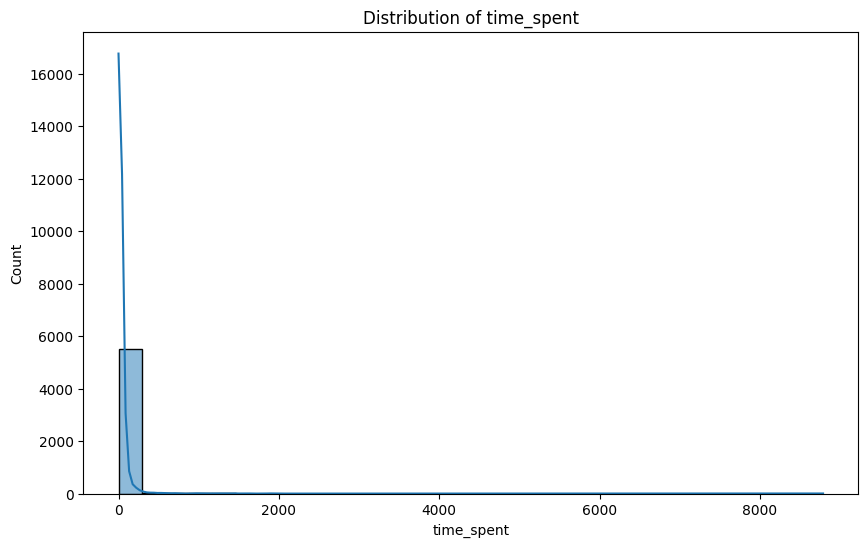

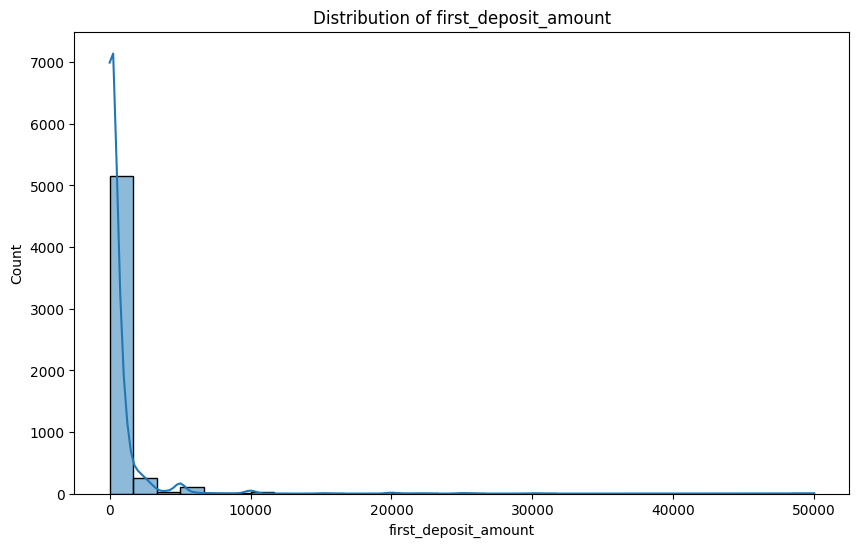

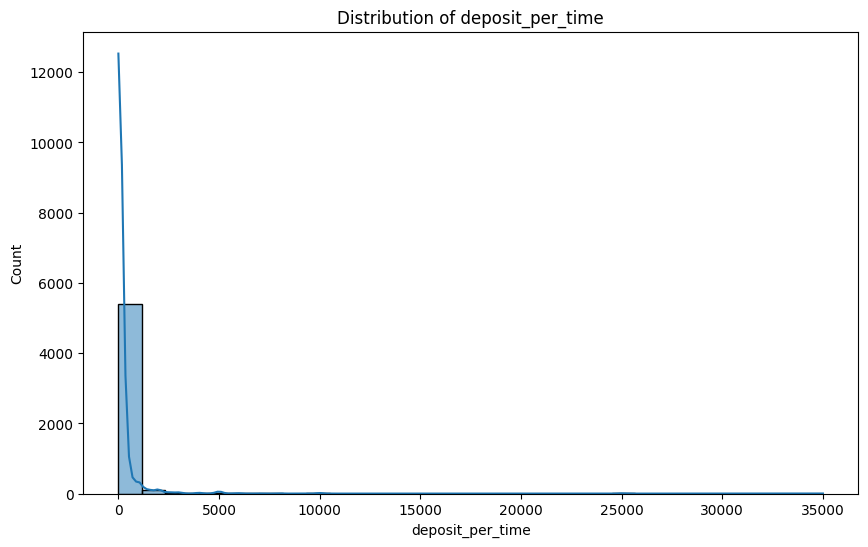

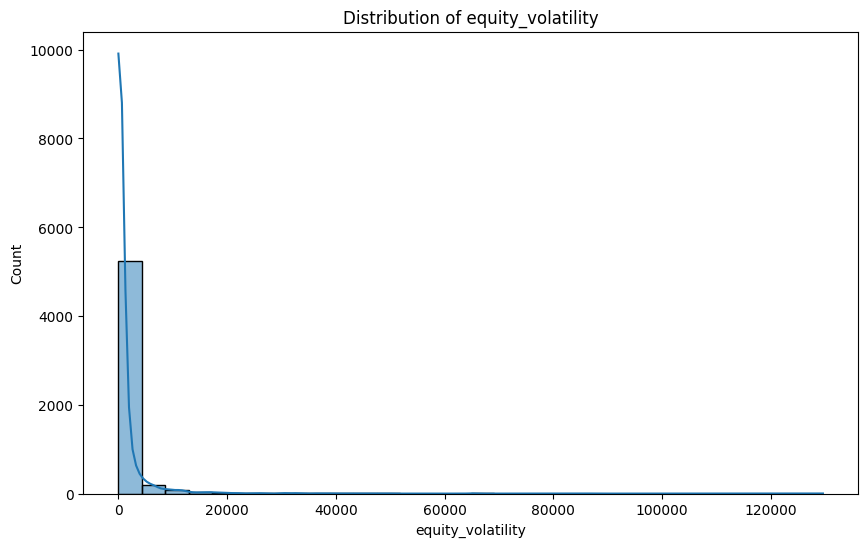

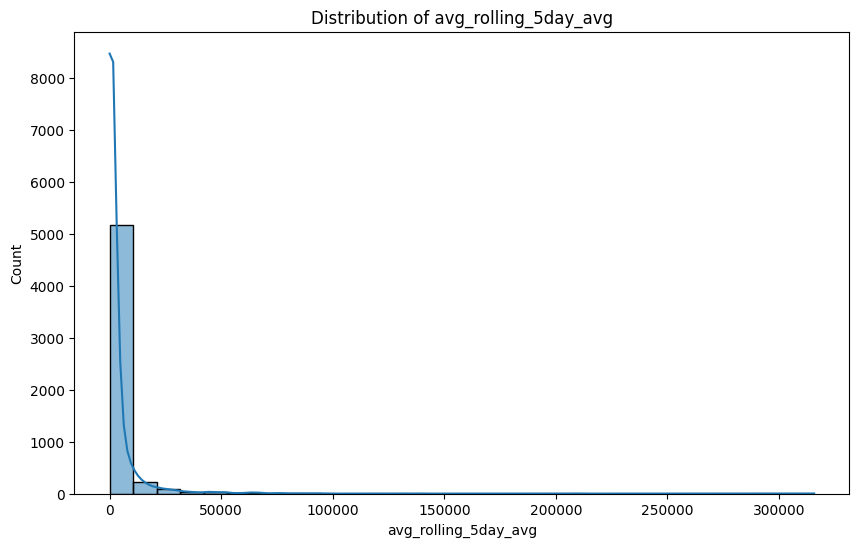

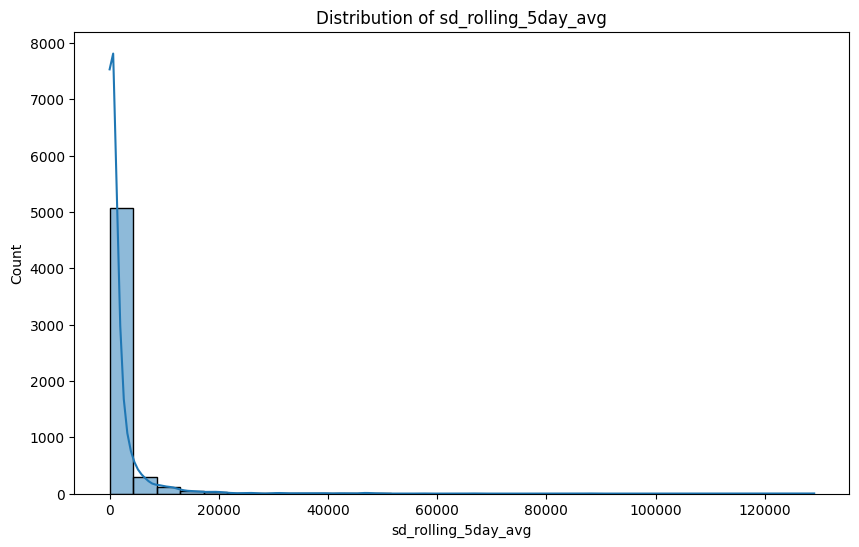

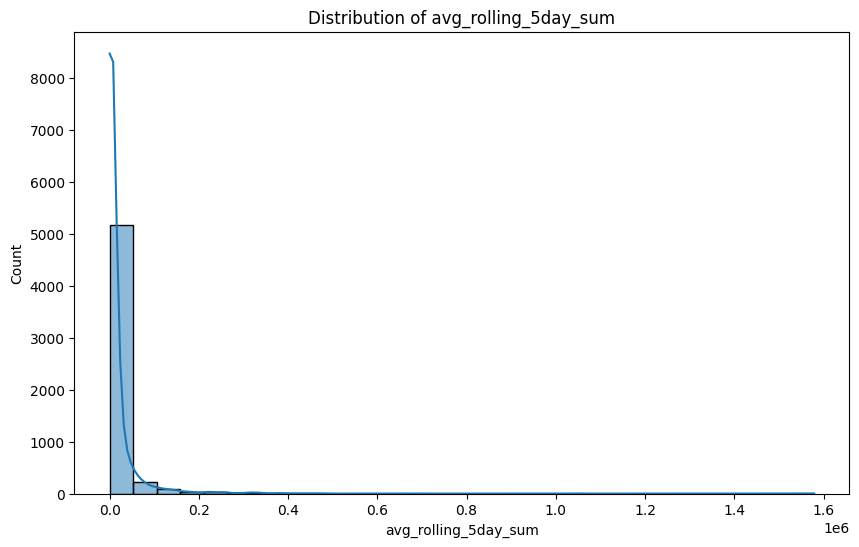

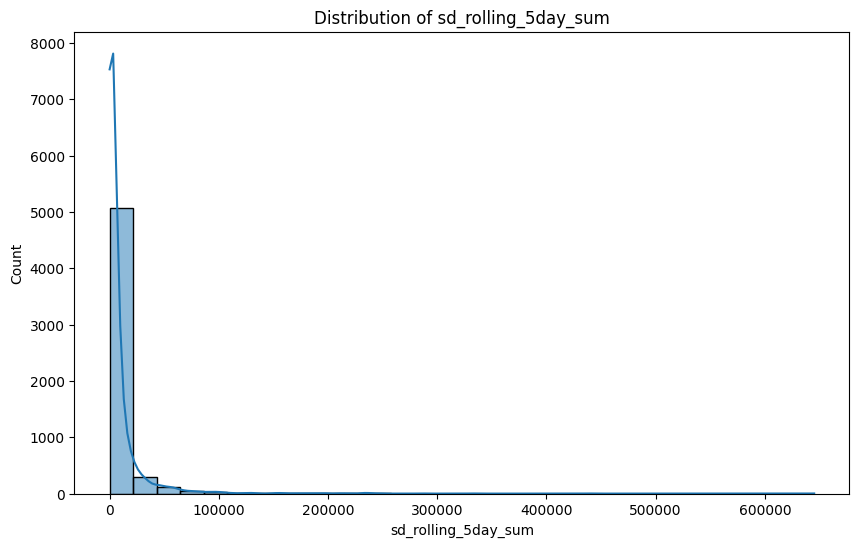

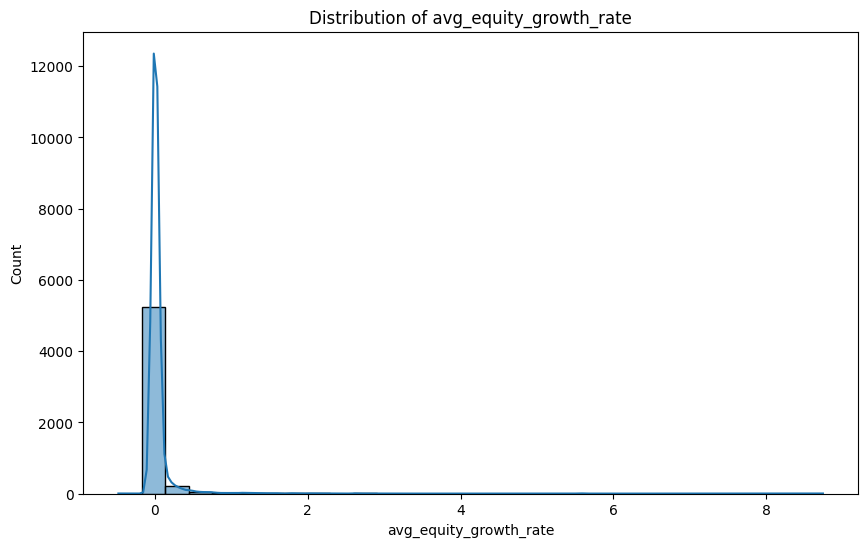

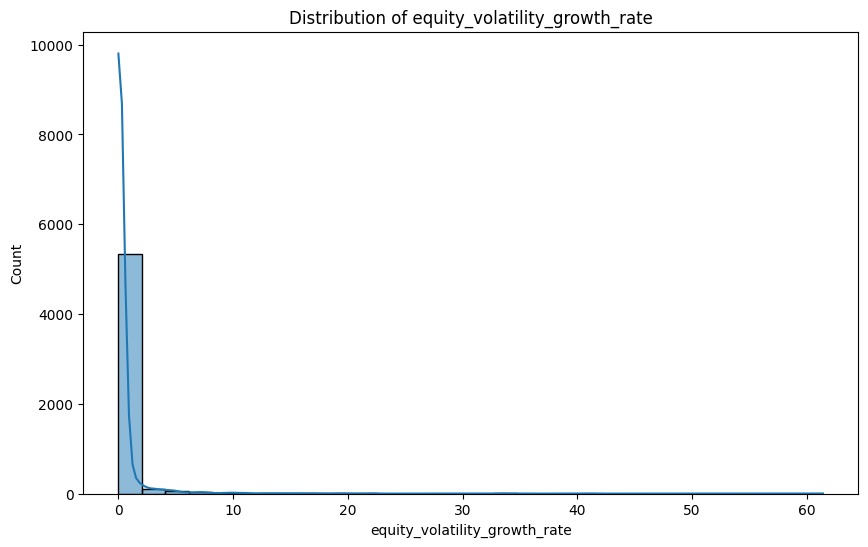

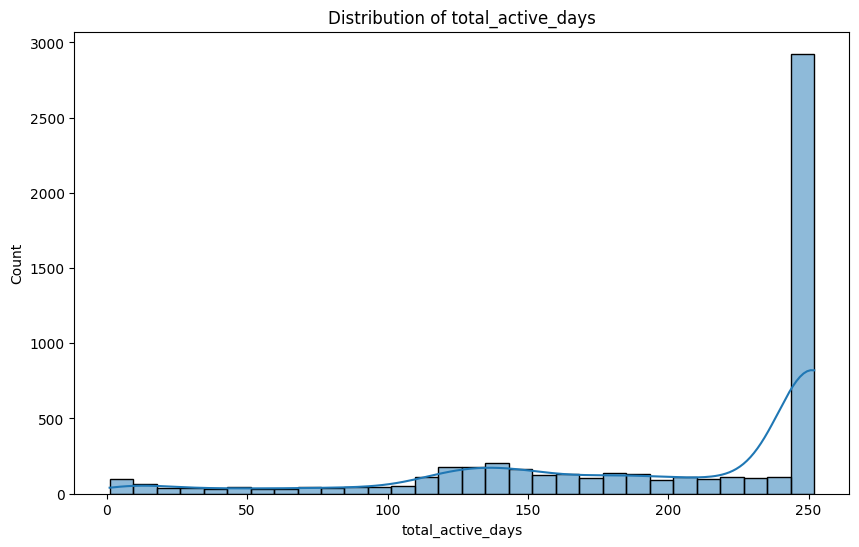

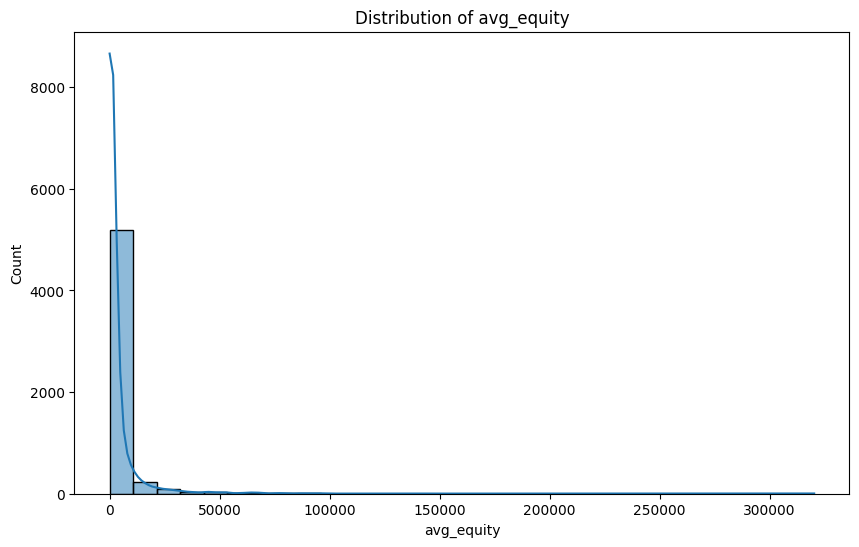

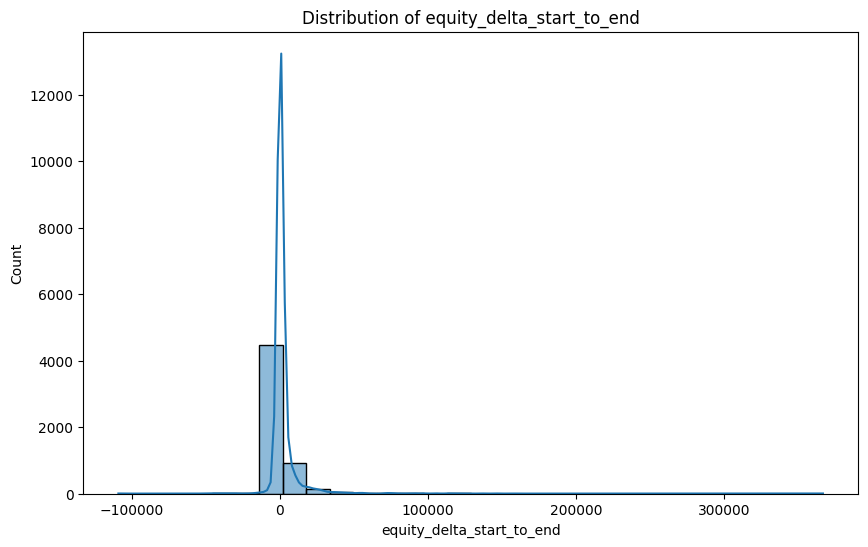

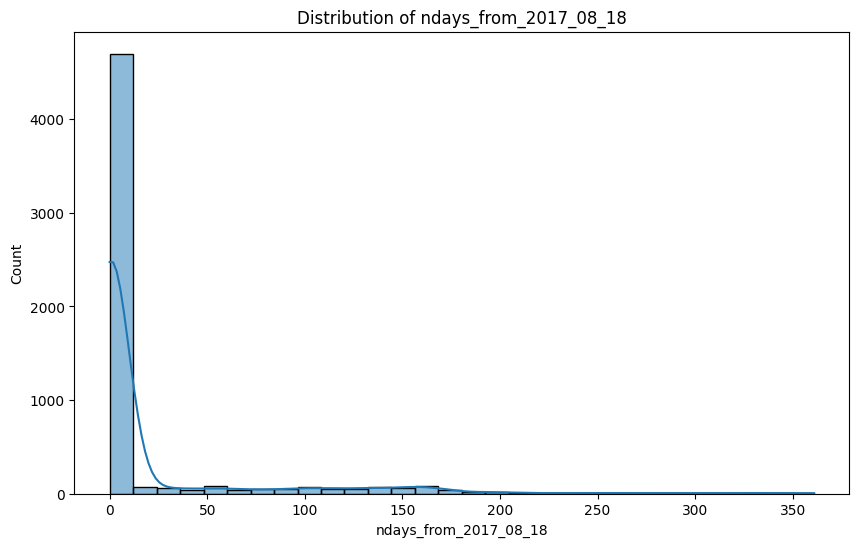

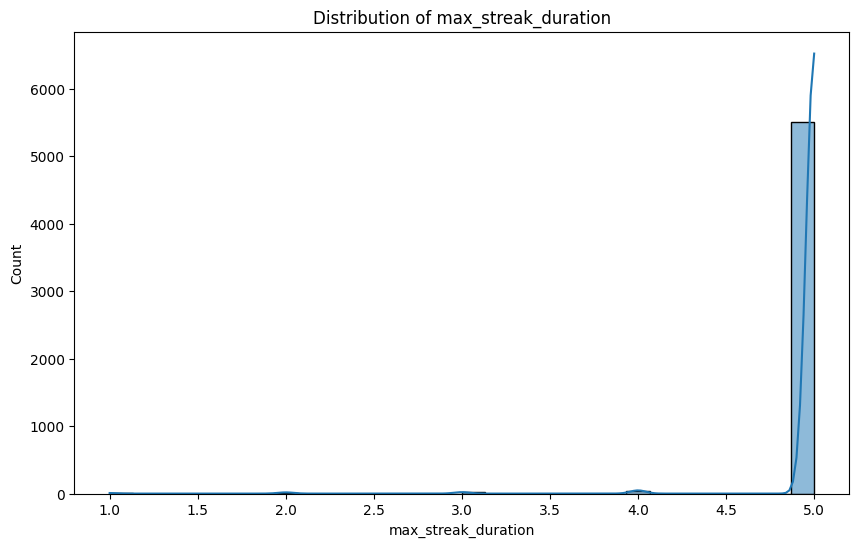

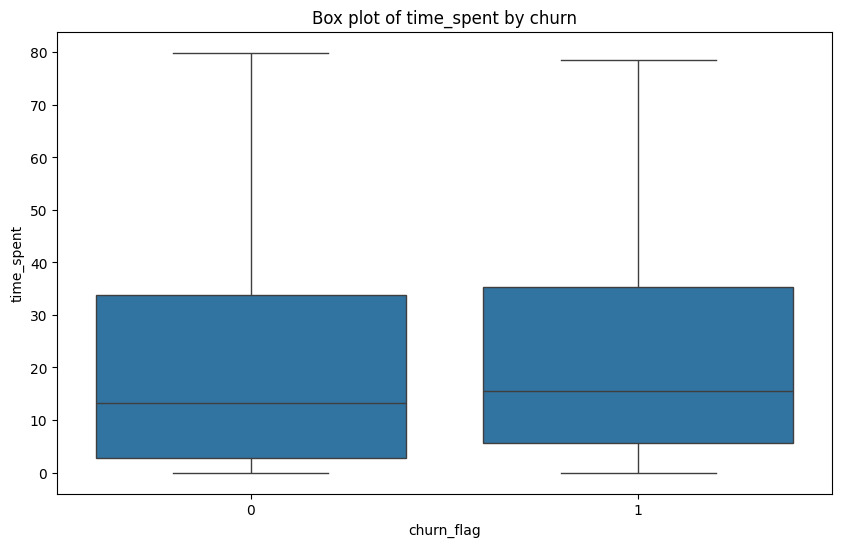

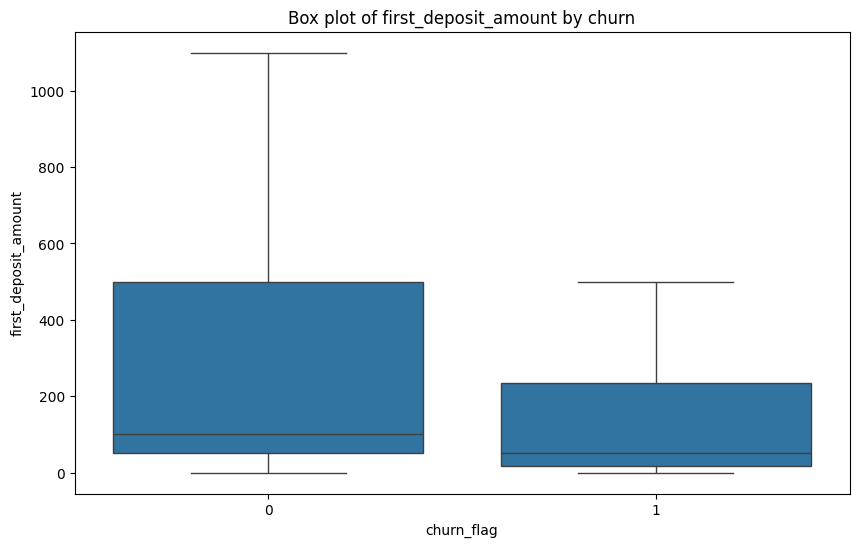

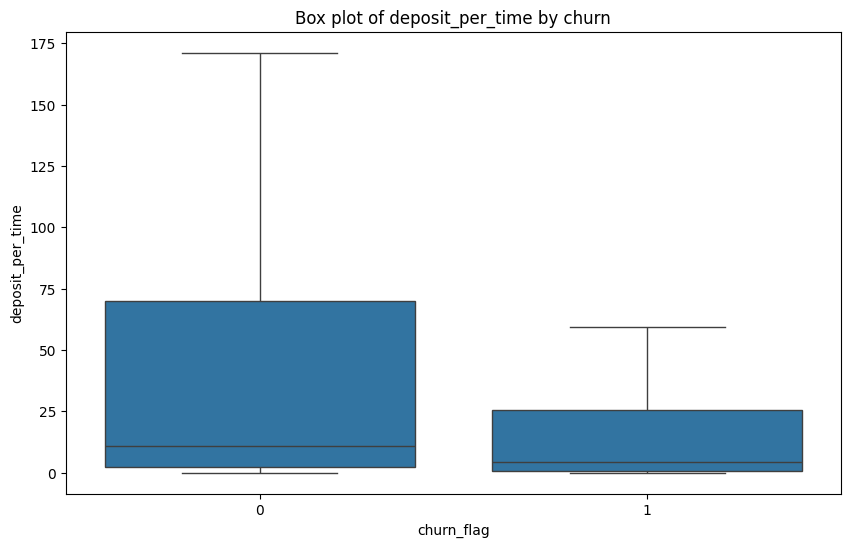

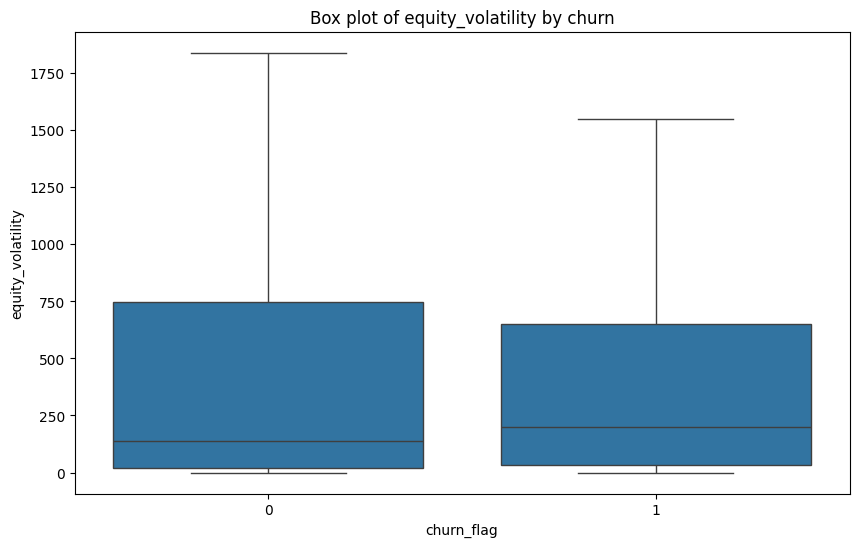

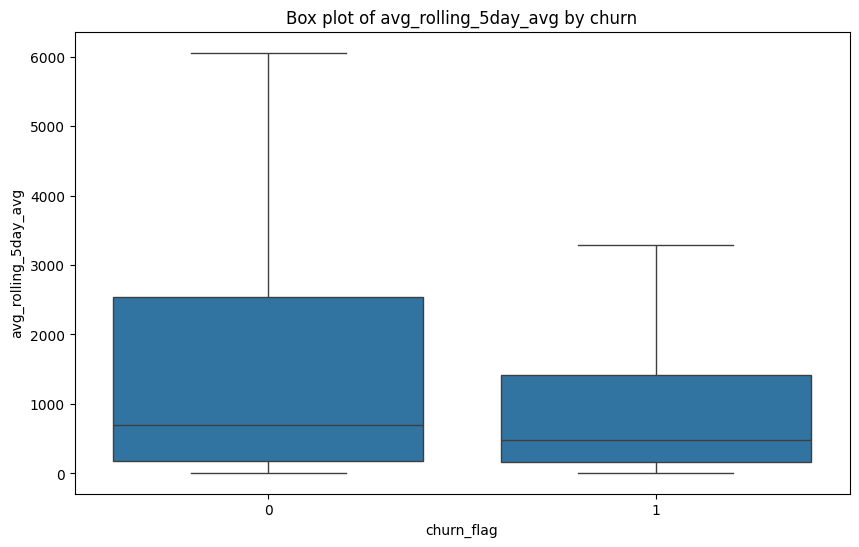

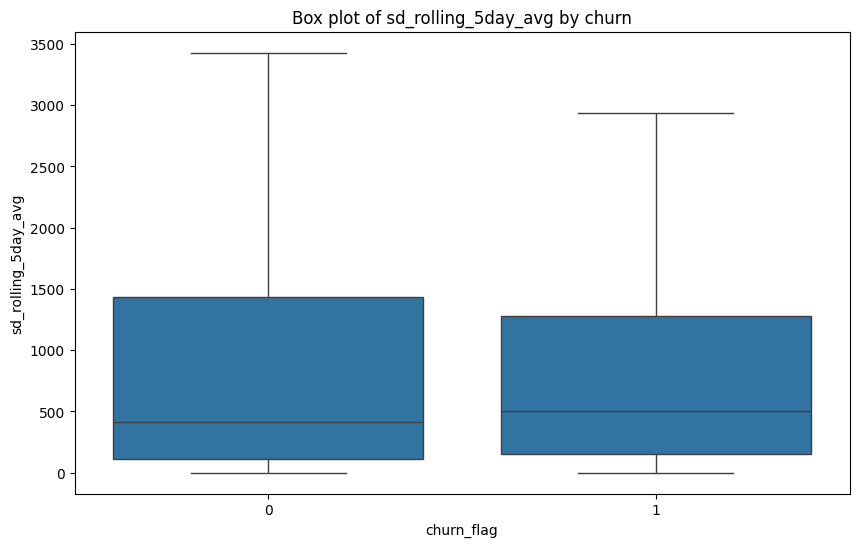

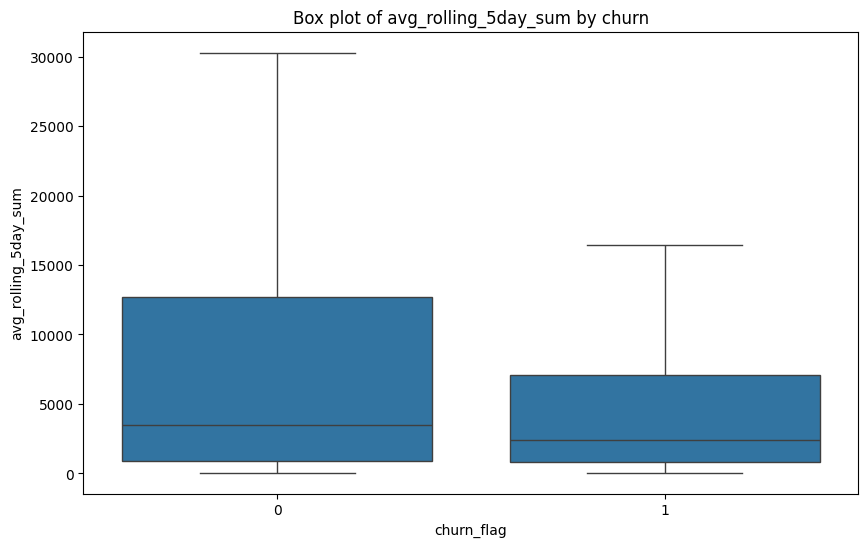

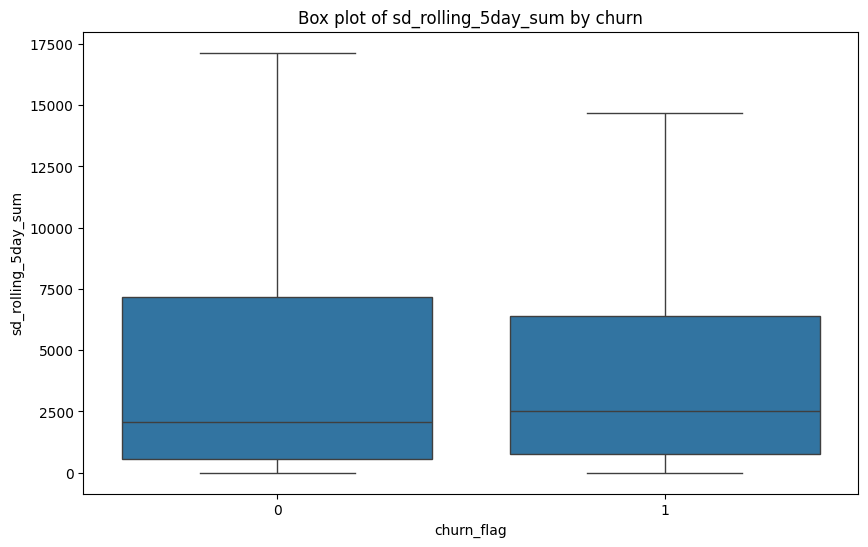

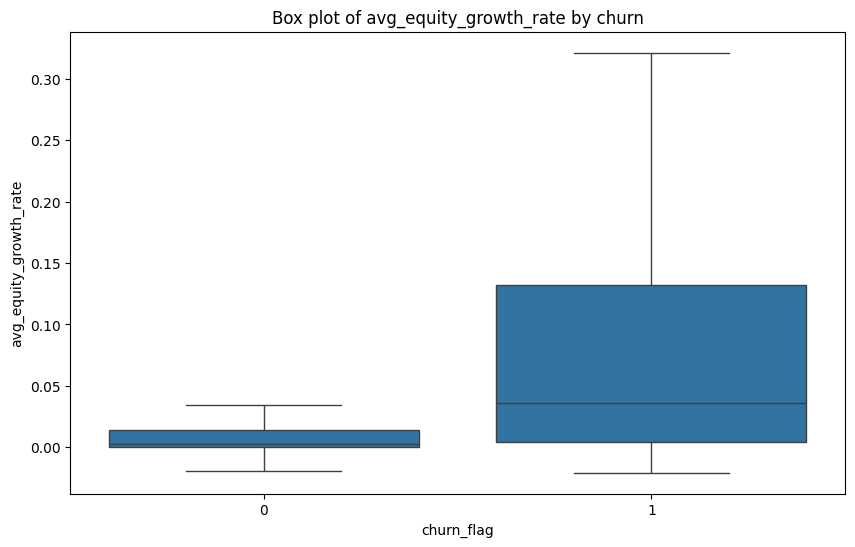

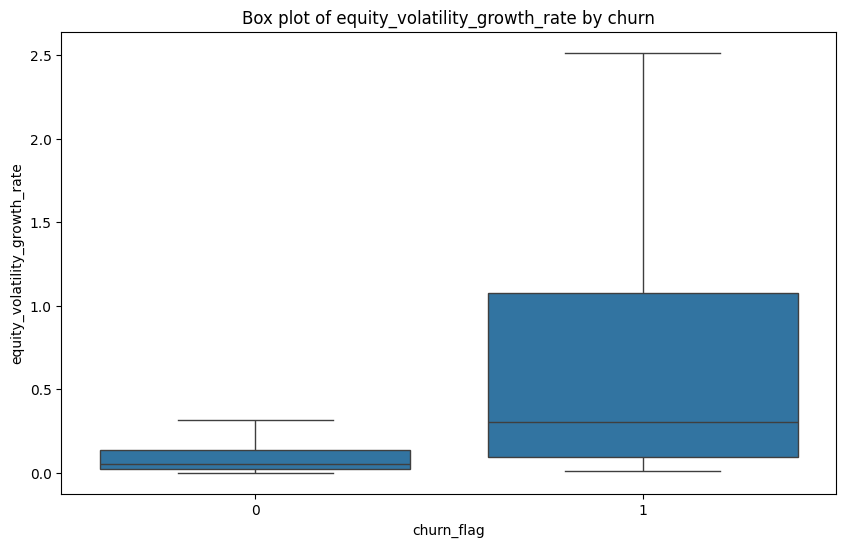

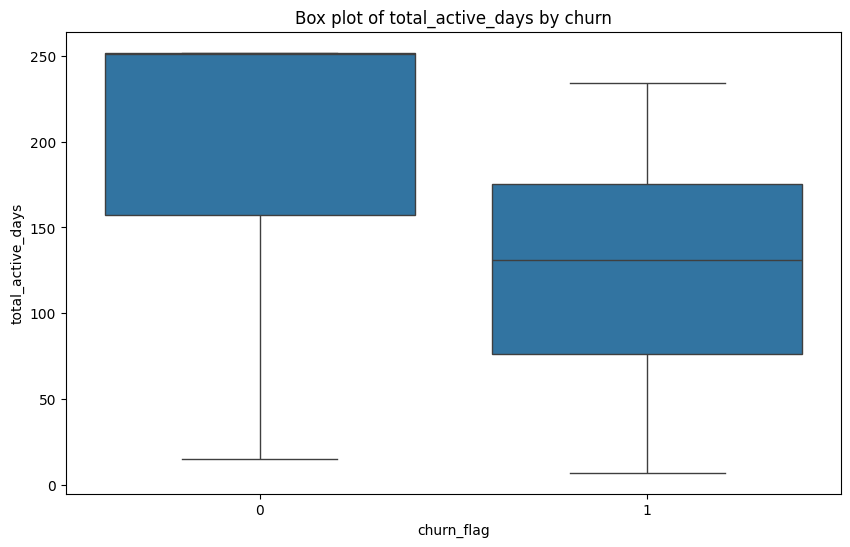

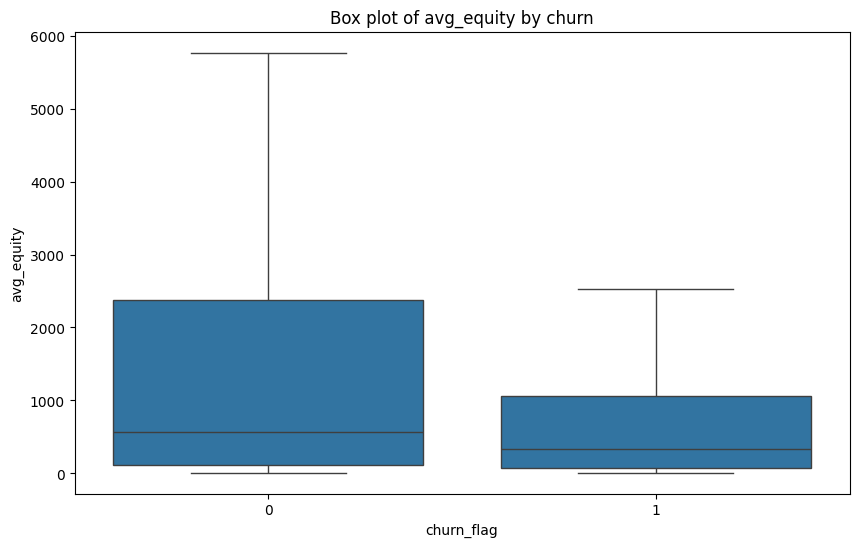

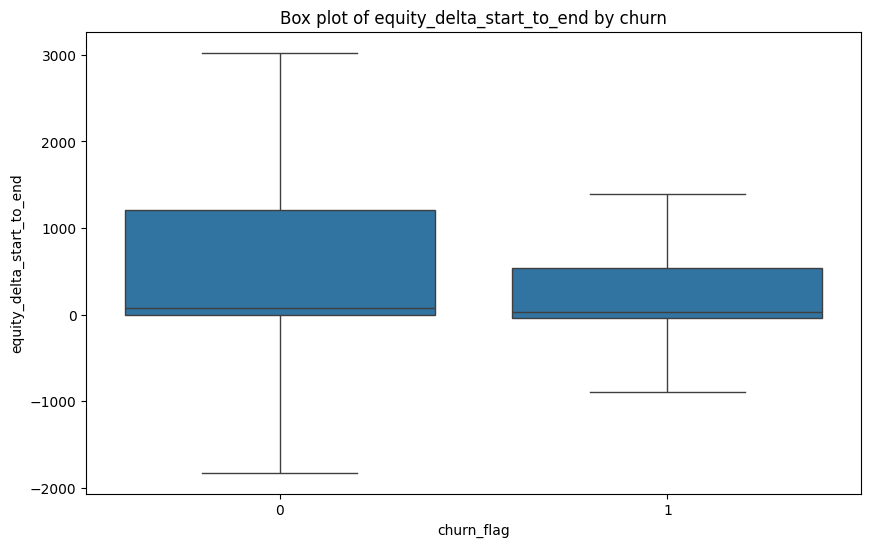

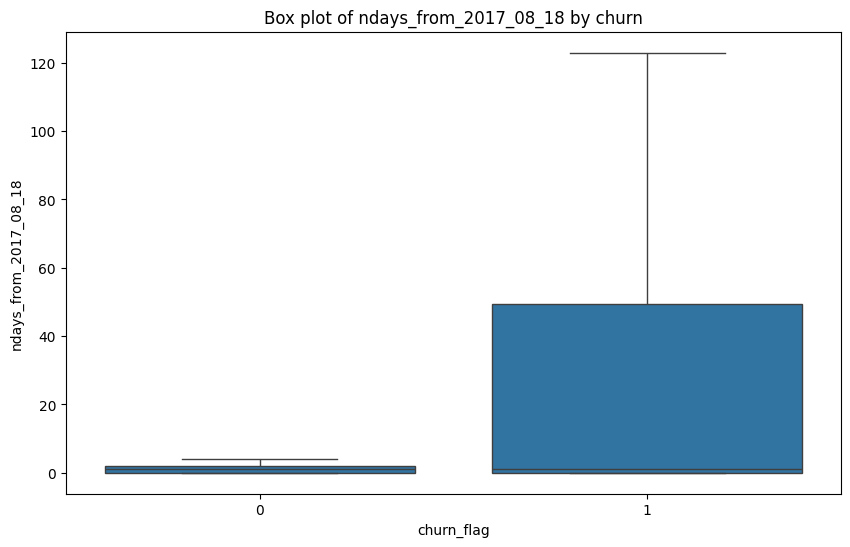

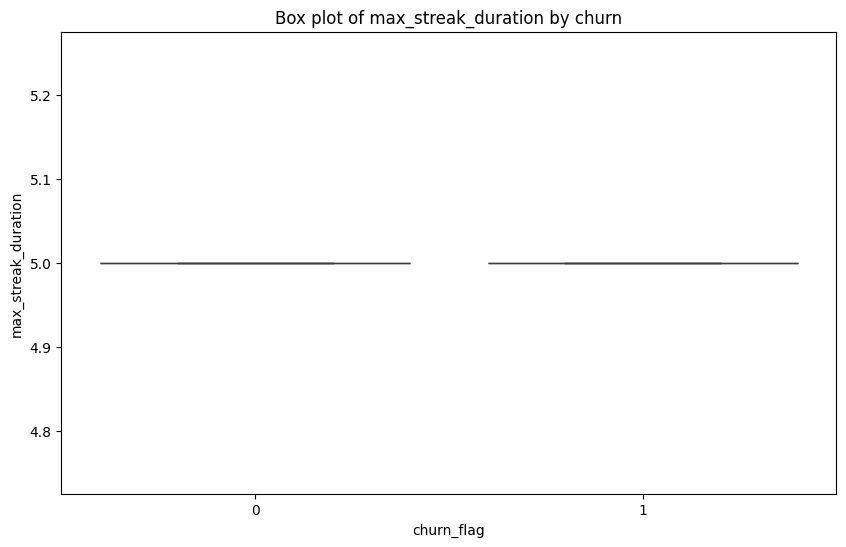

In [311]:
# Distribution plot for numerical features
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.show()

# Box plot for numerical features to detect outliers
for col in num_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='churn_flag', y=col, data=df, showfliers=False)
    plt.title(f'Box plot of {col} by churn')
    plt.show()

### Univariate Analysis | Categorical Features: Frequency distributions

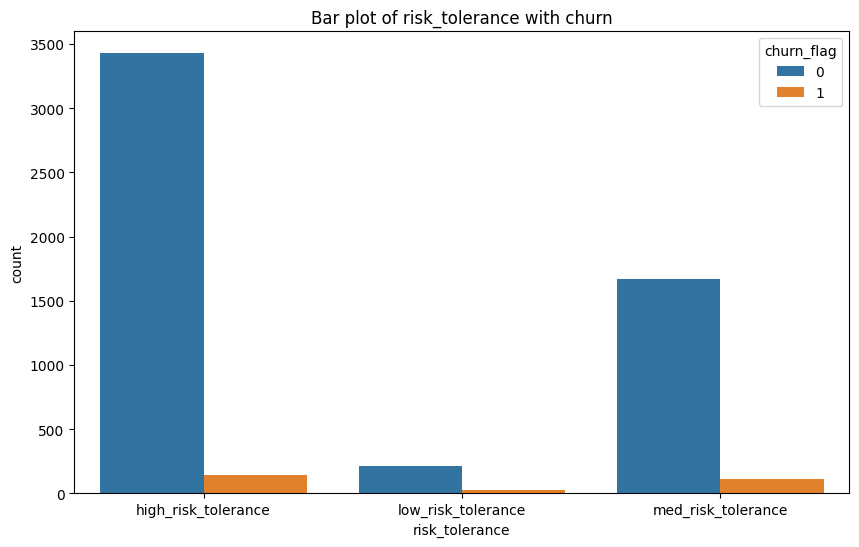

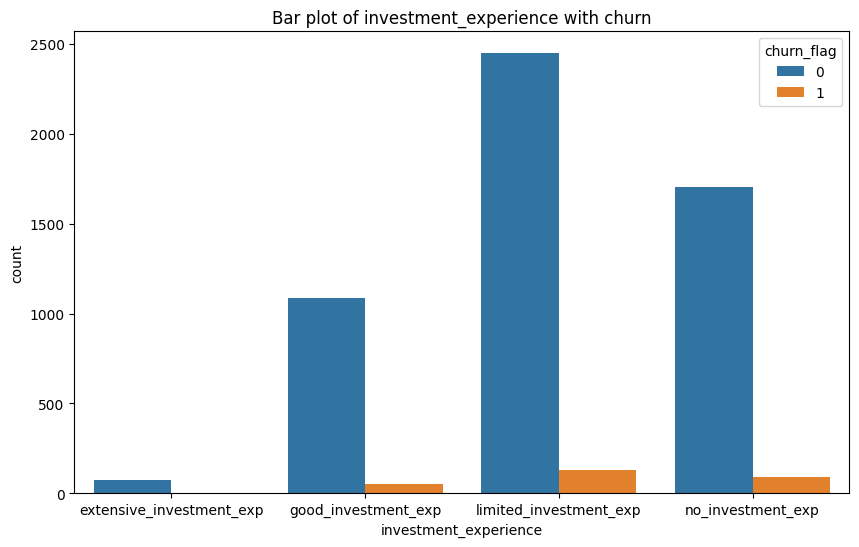

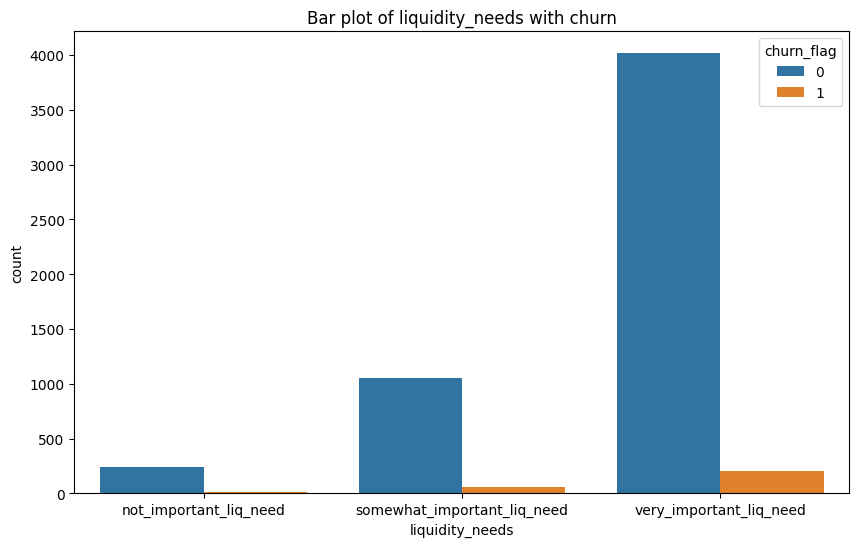

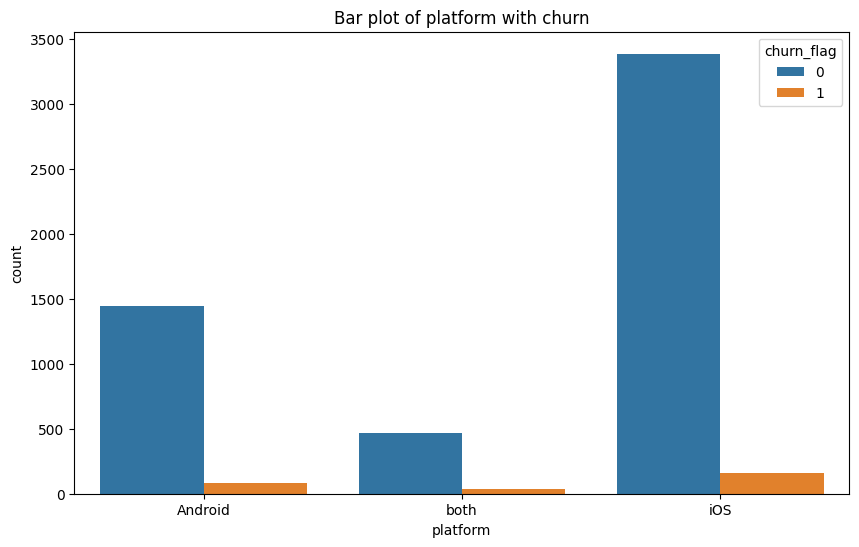

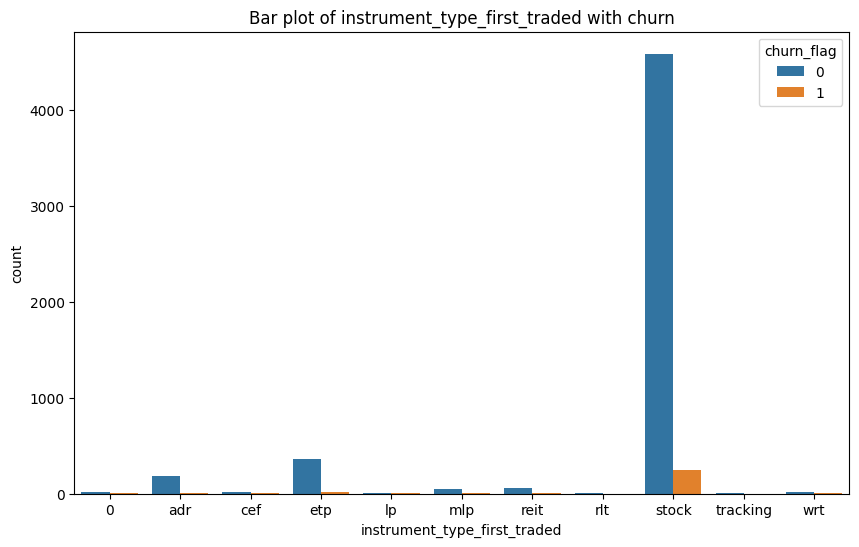

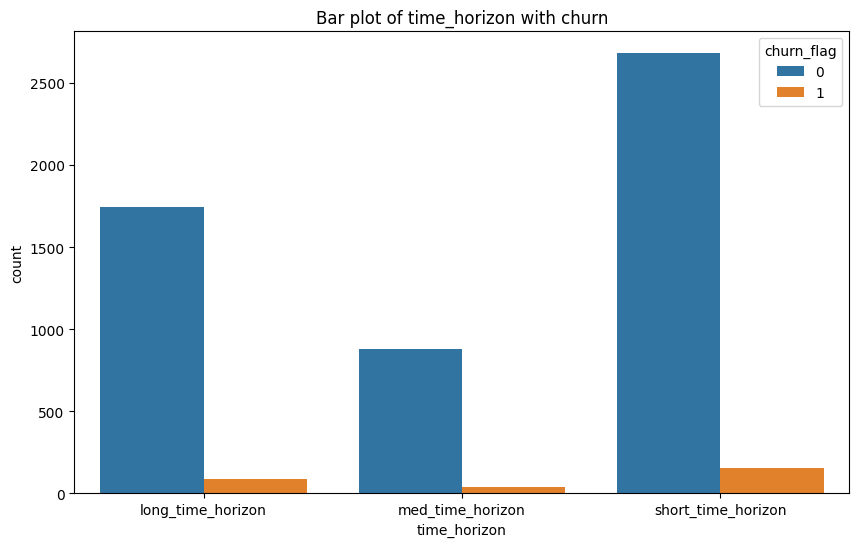

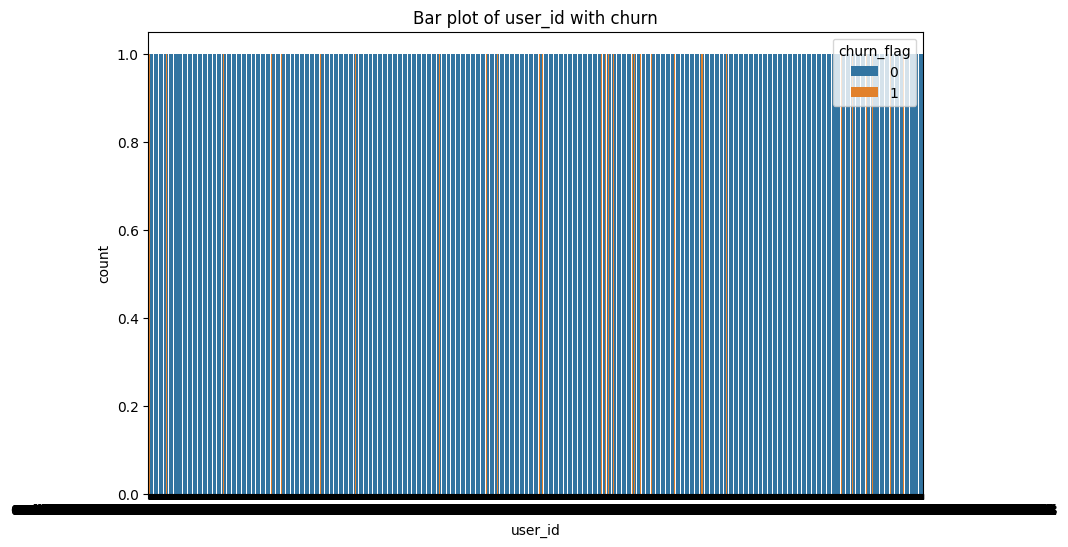

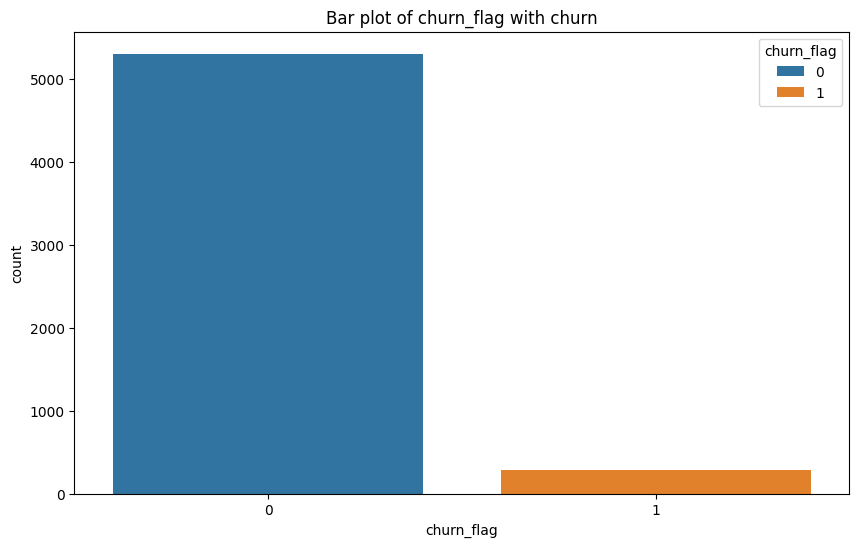

In [312]:
# Bar plot for categorical features
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=df, hue='churn_flag')
    plt.title(f'Bar plot of {col} with churn')
    plt.show()

### Multivariate Analysis | Interactions and Correlations

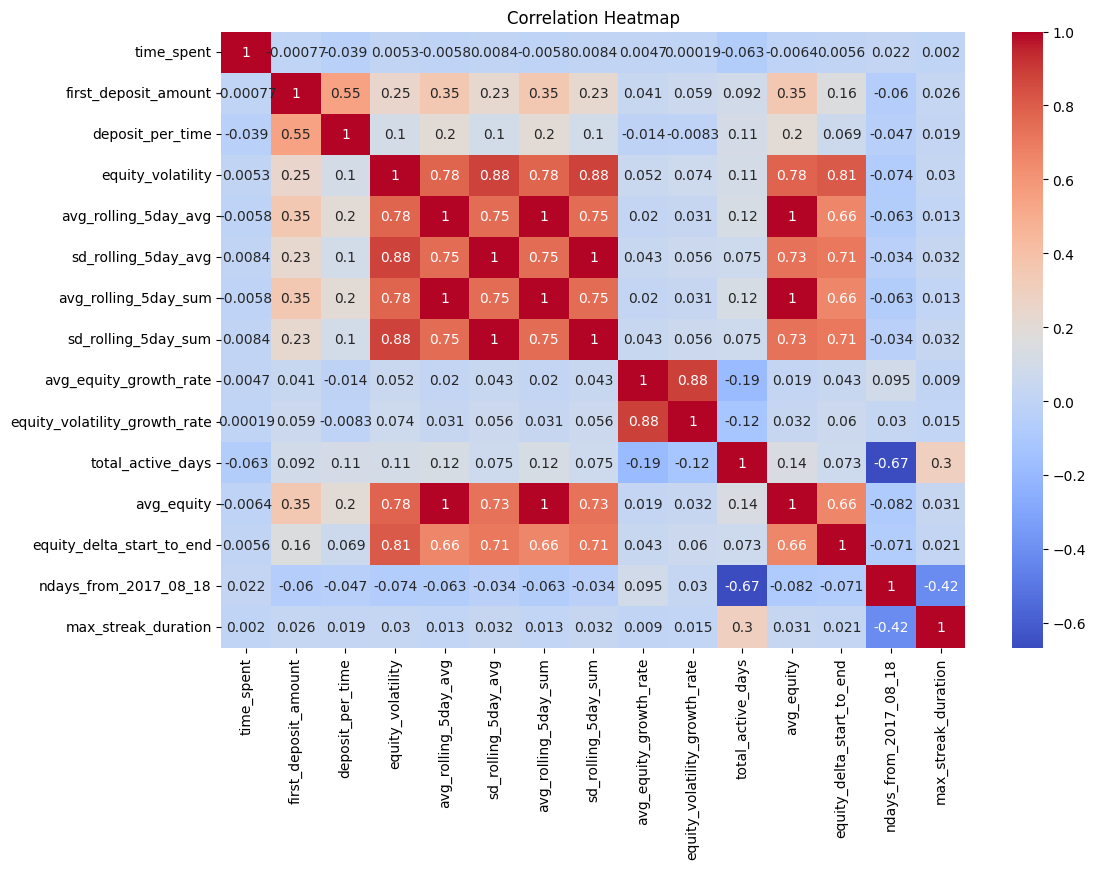

In [315]:
# Correlation matrix and heatmap to understand relationships between numerical variables.
# Filter out only numerical columns
num_cols_temp = df.select_dtypes(include=['float64', 'int64'])

# Correlation matrix and heatmap to understand relationships between numerical variables.
plt.figure(figsize=(12, 8))
corr = num_cols_temp.corr()  # Calculate correlation on numerical columns
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

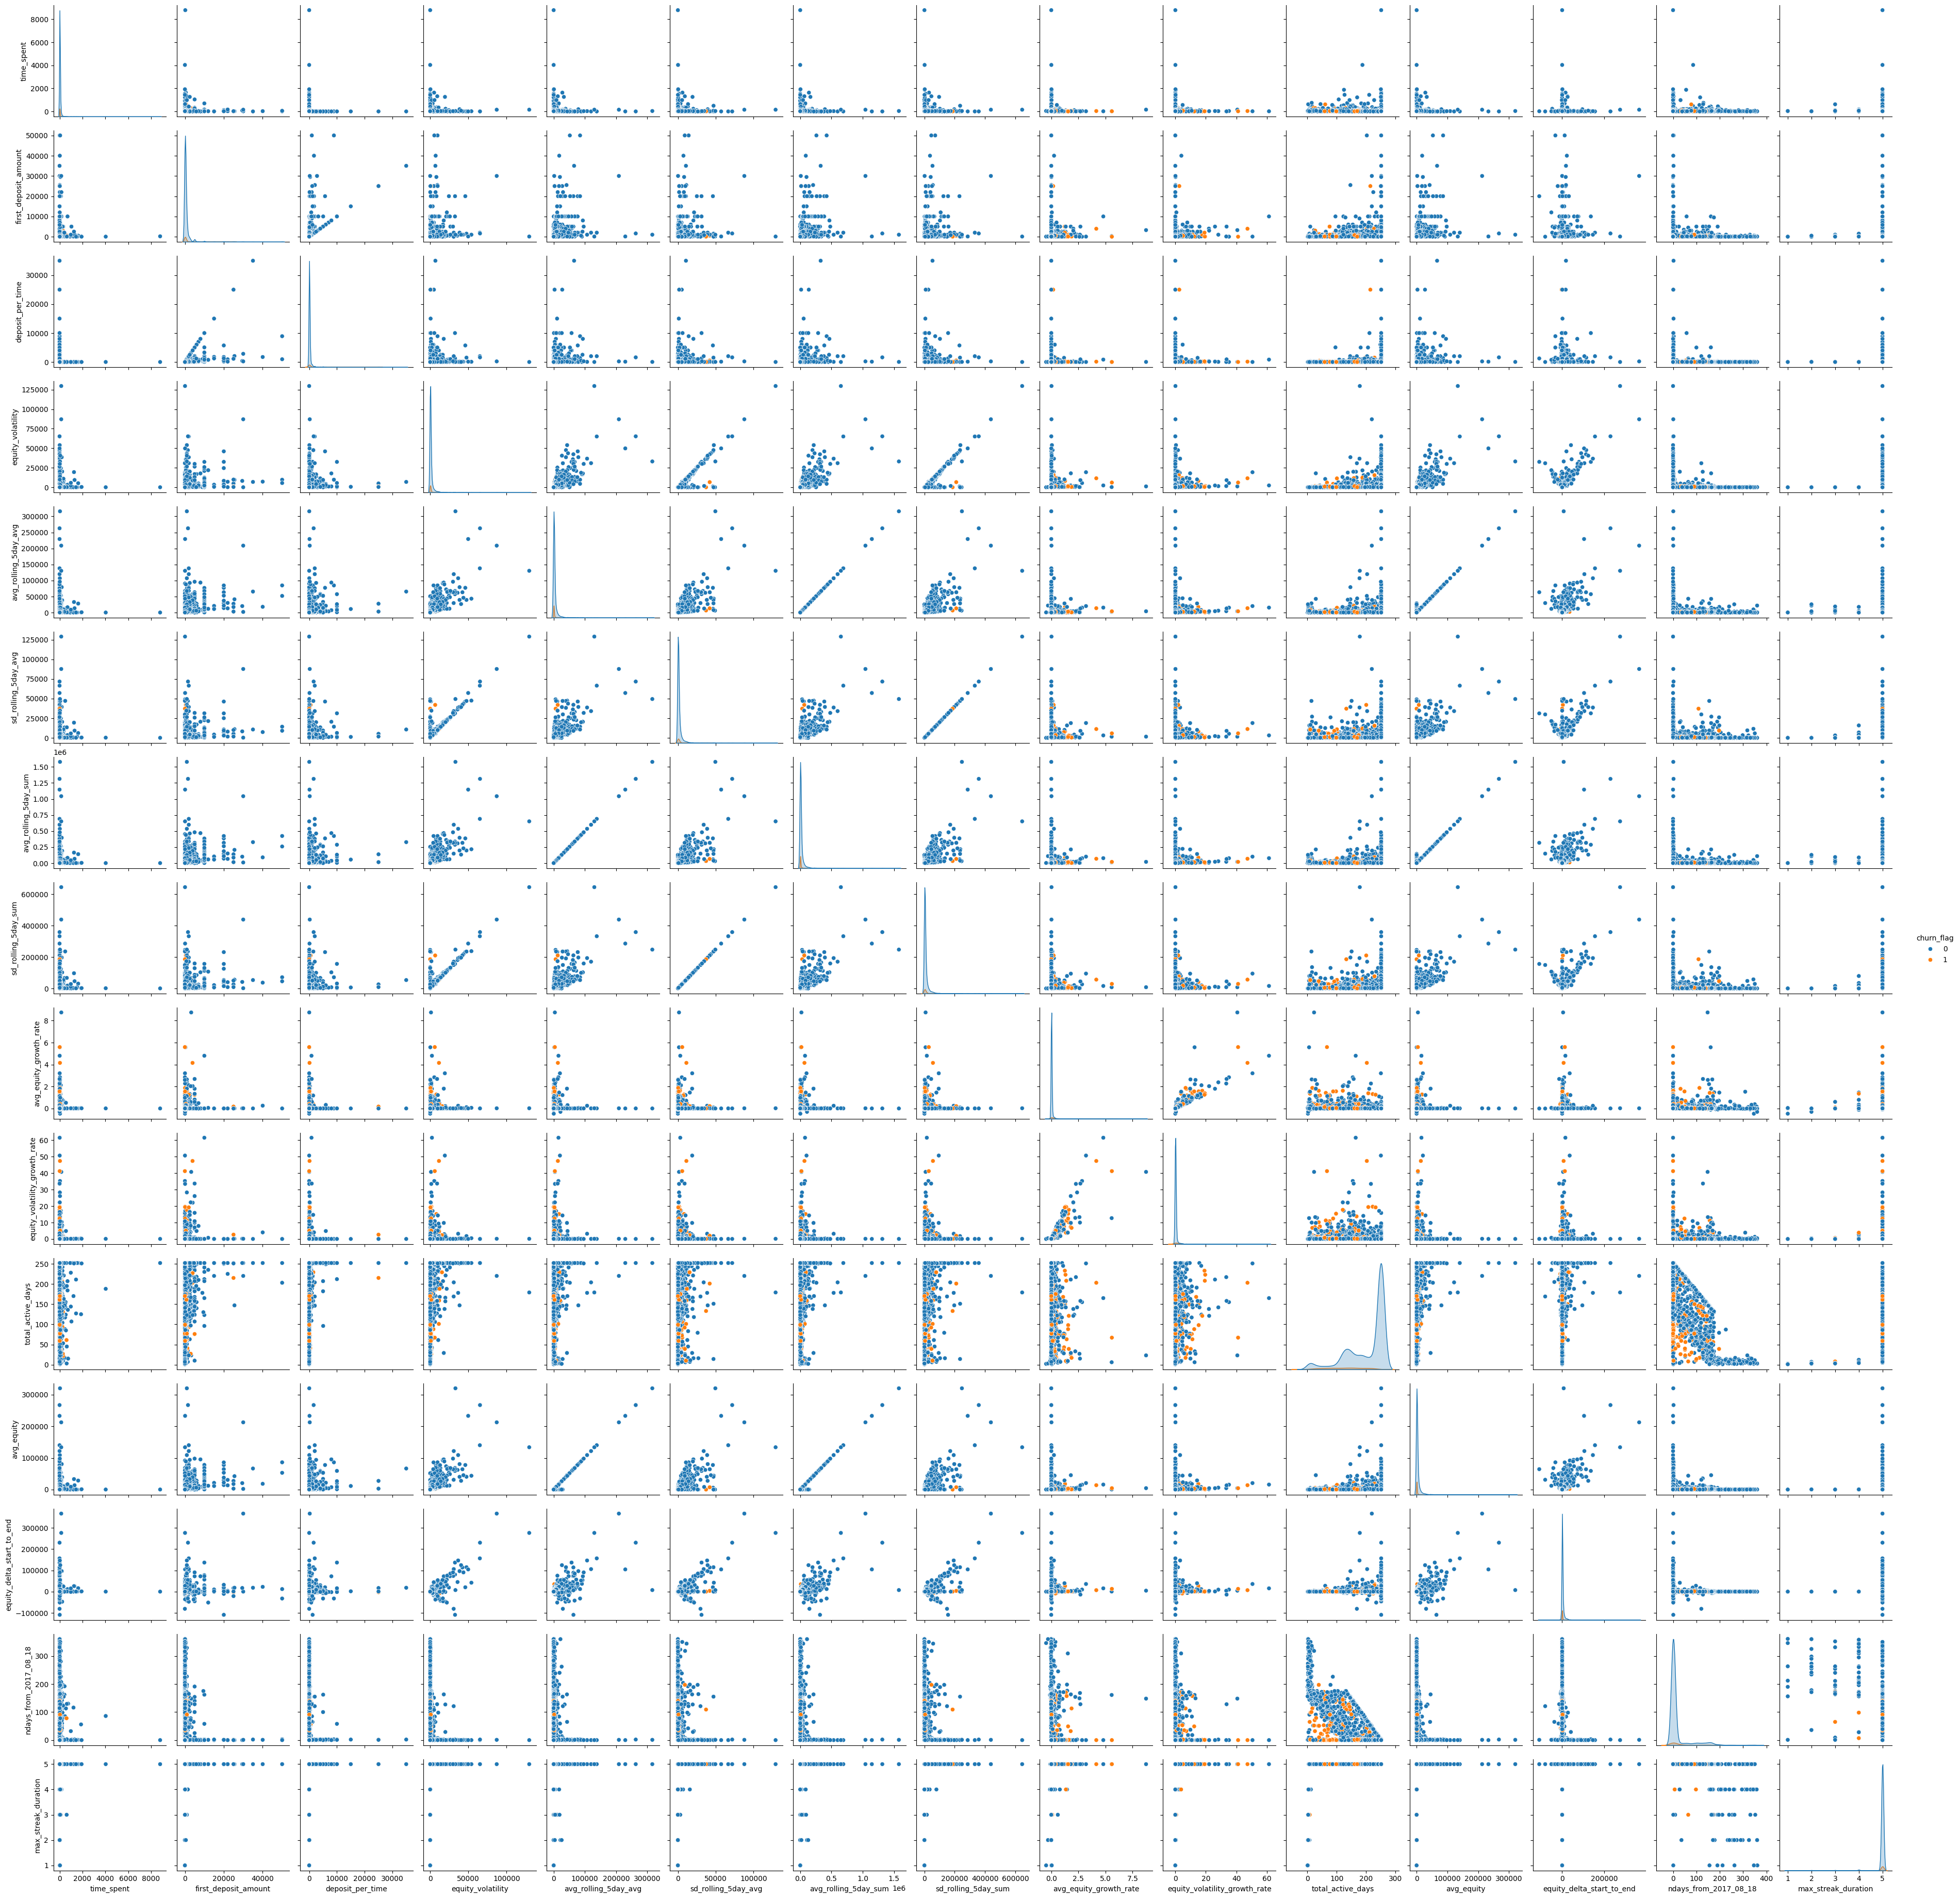

In [316]:
# Pair plot to see pairwise relationships
sns.pairplot(df, hue='churn_flag', vars=num_cols)
plt.show()

### Understanding Distribution Patterns (Normal, Bimodal, Skewed)



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



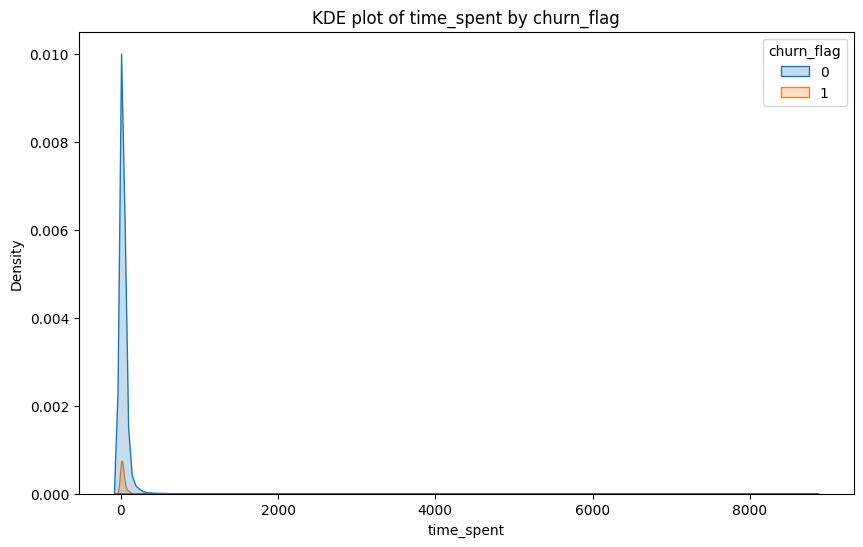



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



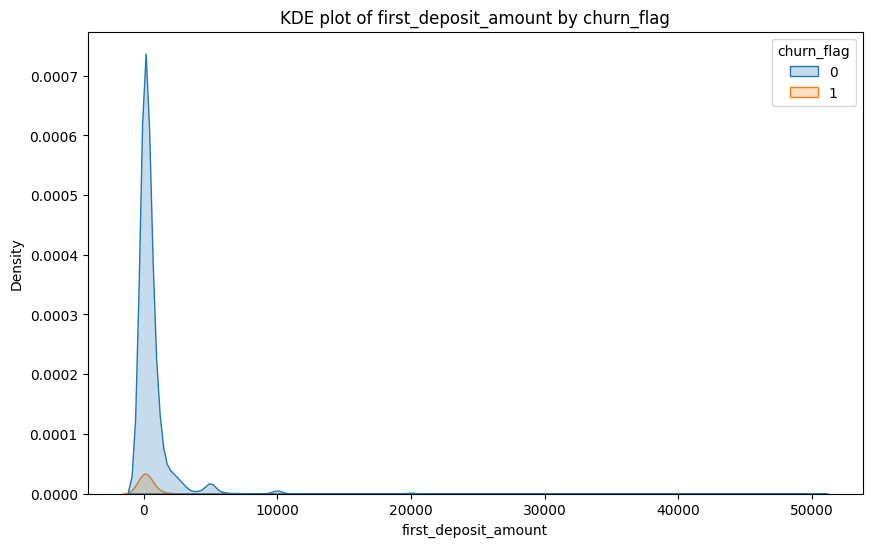



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



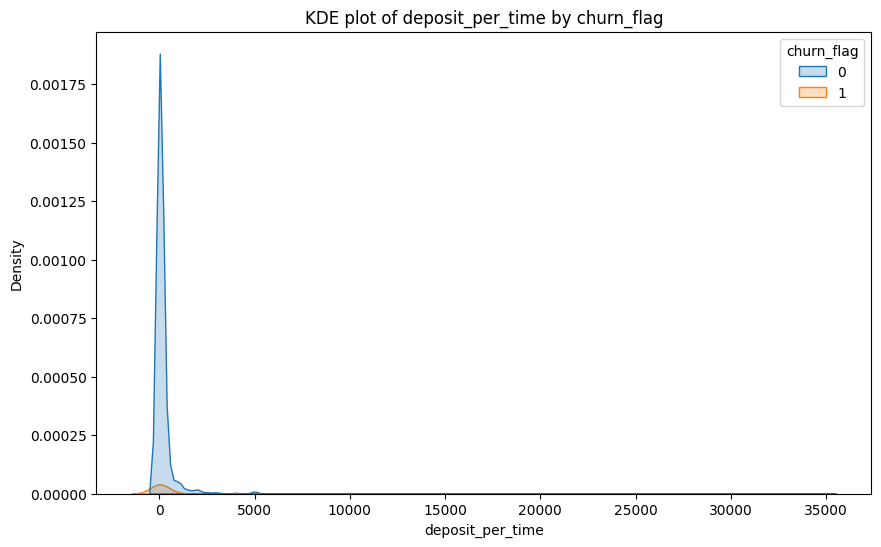



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



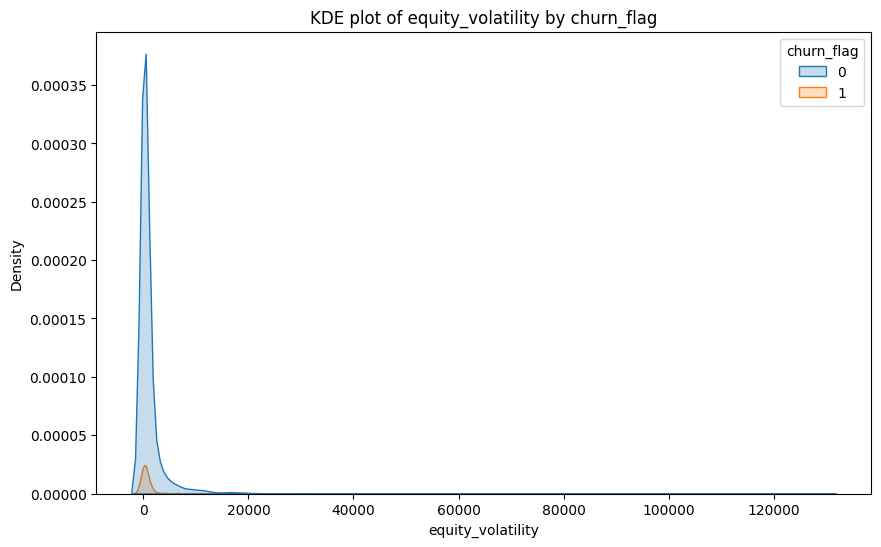



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



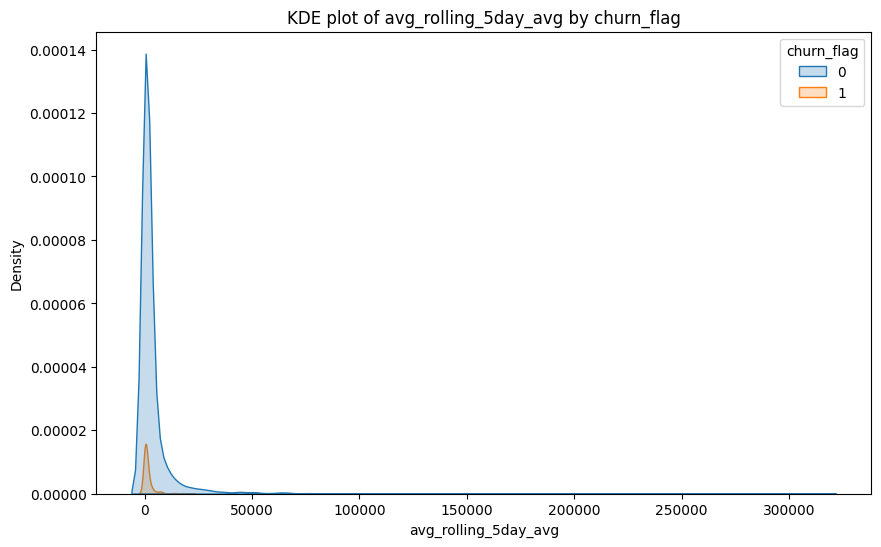



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



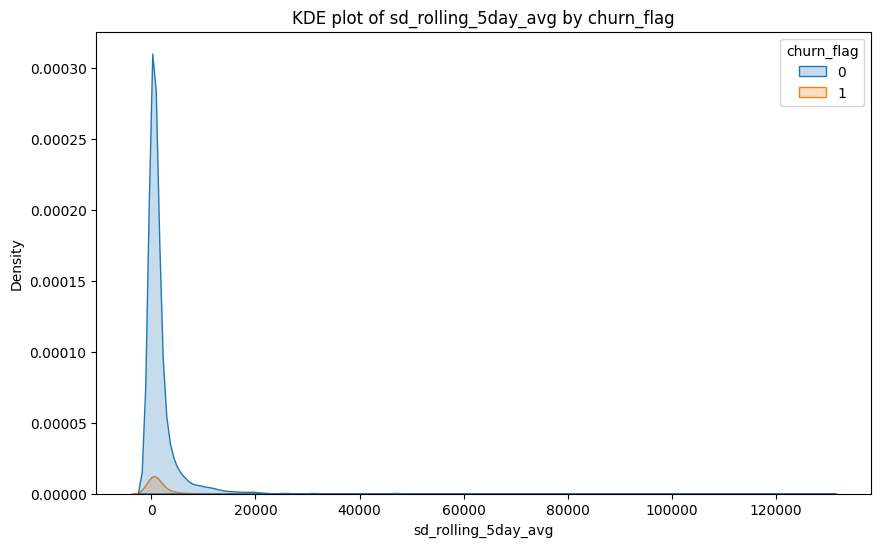



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



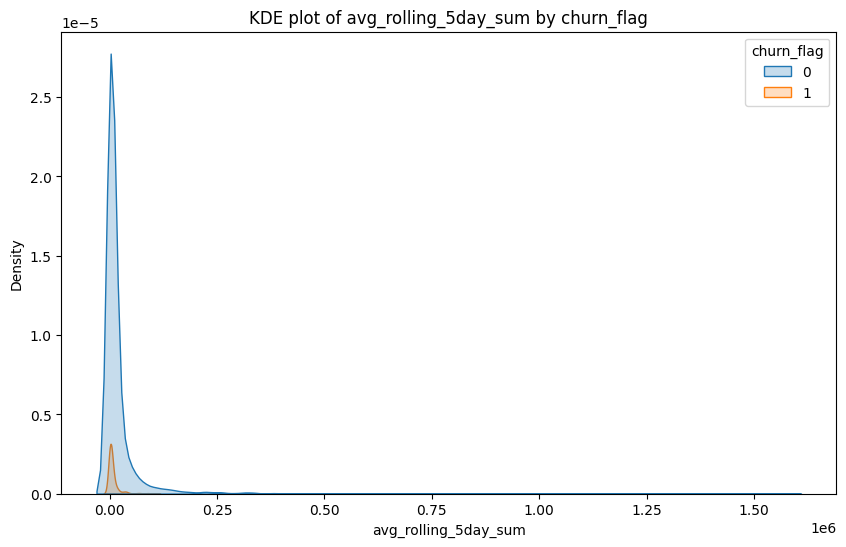



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



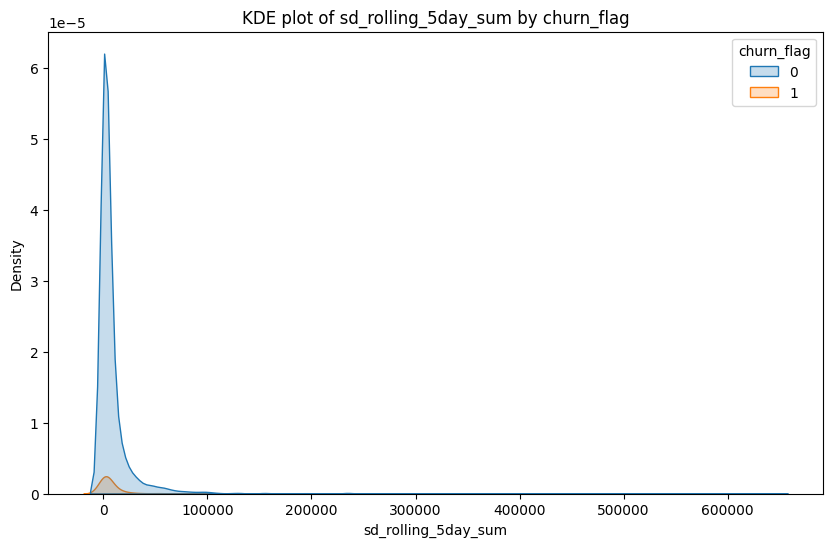



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



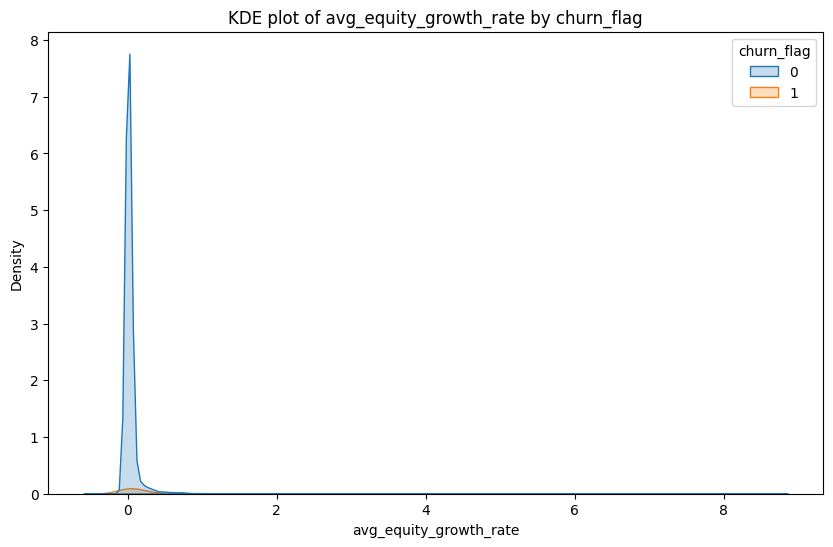



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



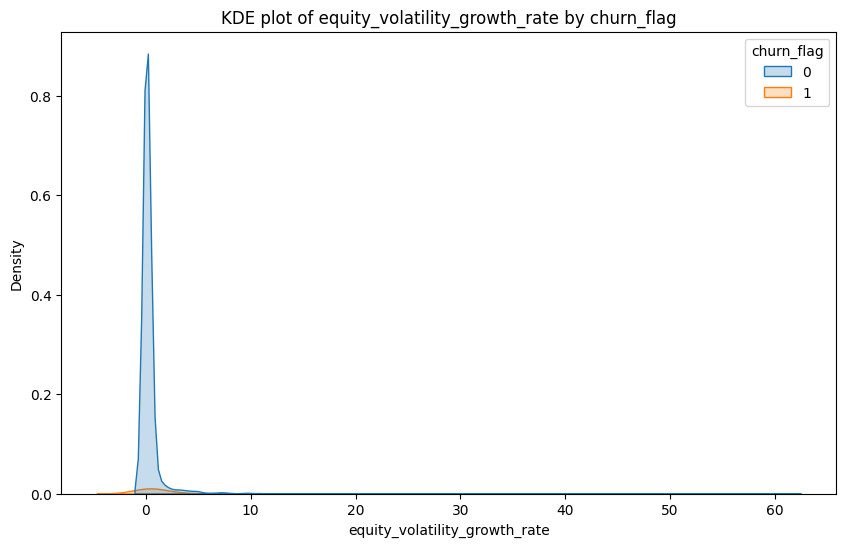



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



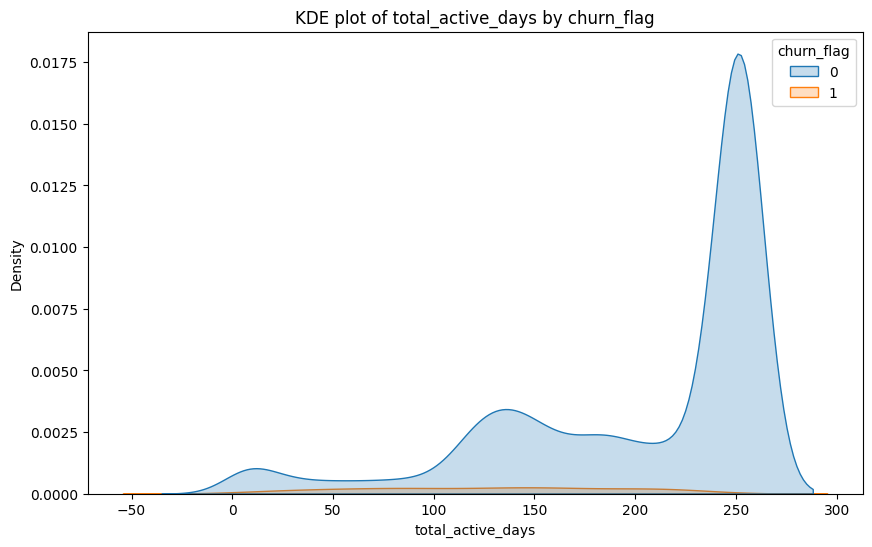



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



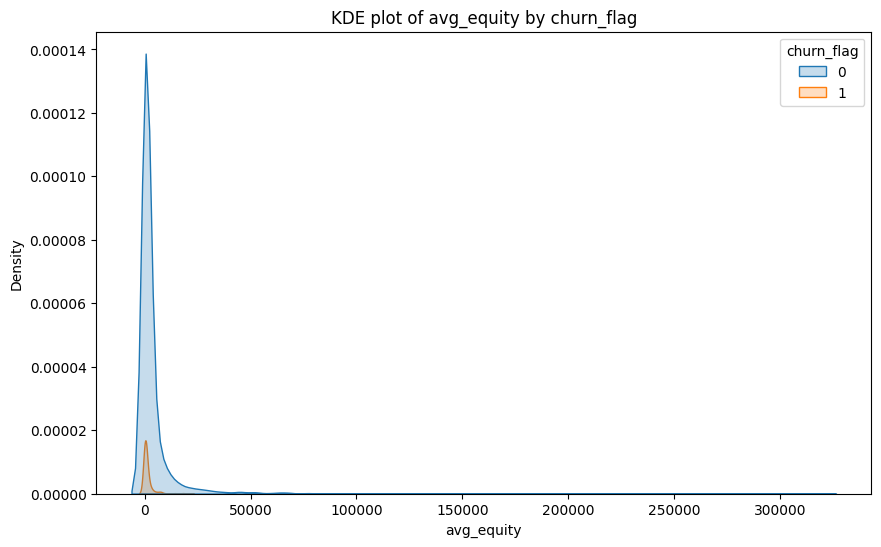



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



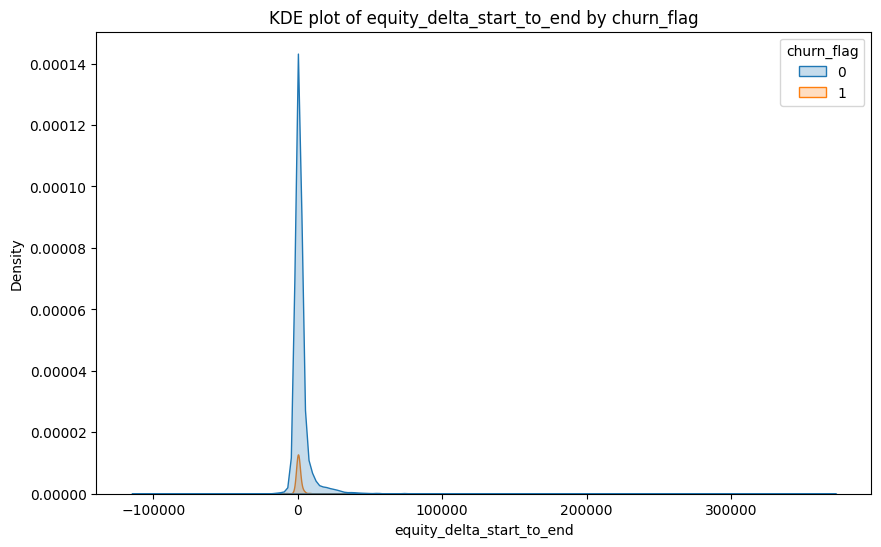



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



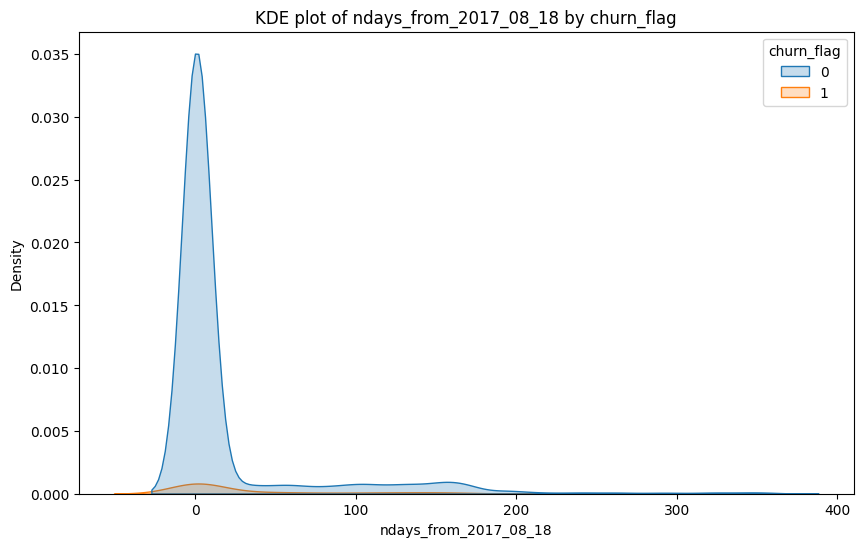



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



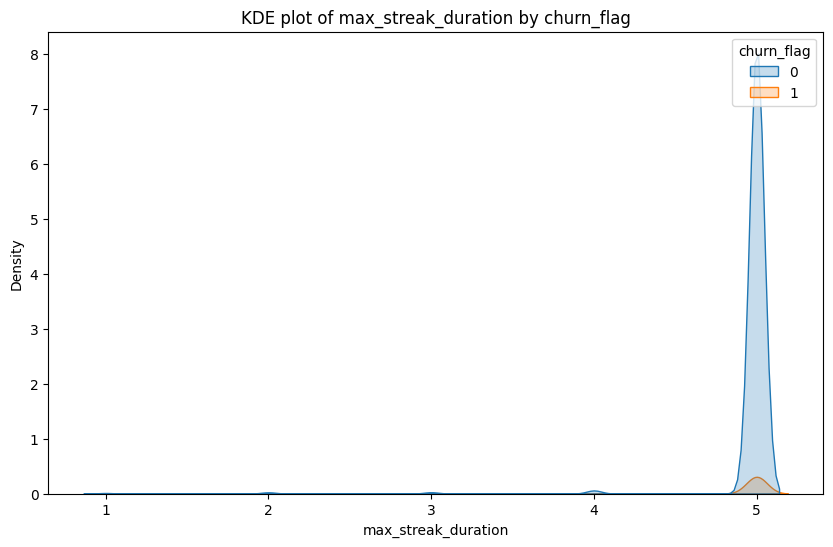

In [317]:
# KDE plot to understand the distribution shape
# Remember 'churn_flag' is treated as categorical since hue parameter needs to be a category
# KDE plot to understand the distribution shape
for col in num_cols:
    plt.figure(figsize=(10, 6))
    # Plot KDE with churn_flag as hue, but only for numeric columns
    sns.kdeplot(data=df, x=col, shade=True, hue='churn_flag')
    plt.title(f'KDE plot of {col} by churn_flag')
    plt.show()

### Categorical Variables and Churn Relationships

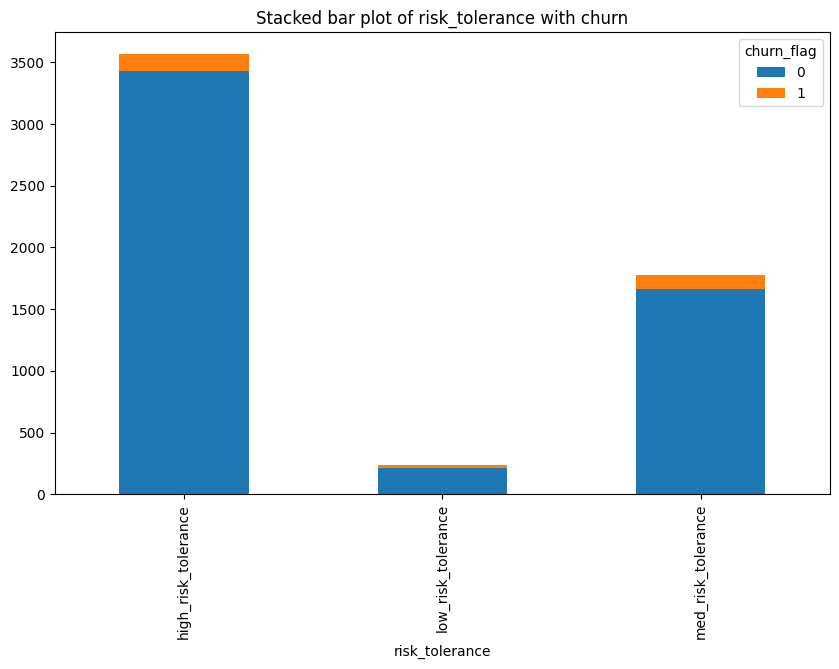

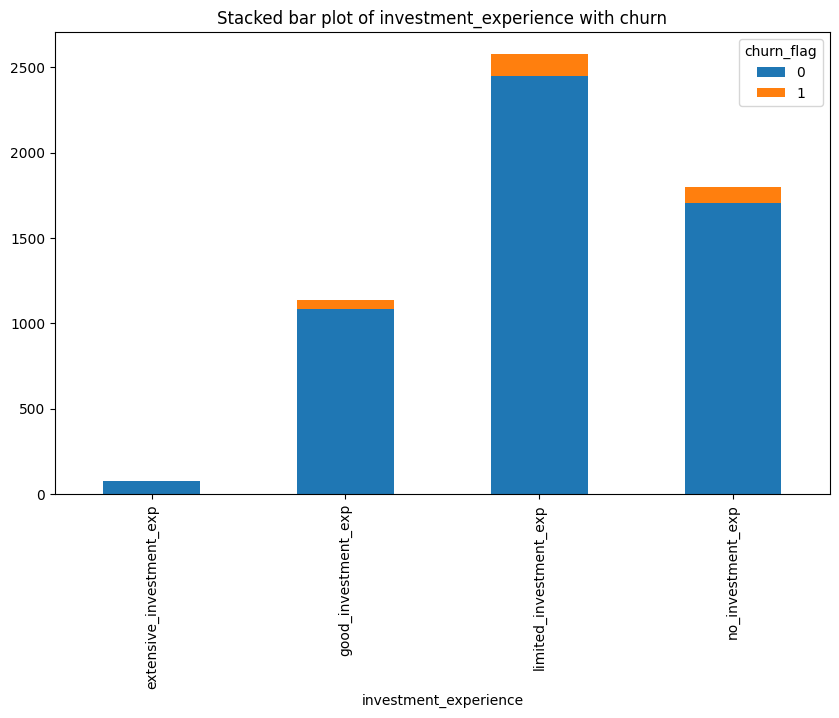

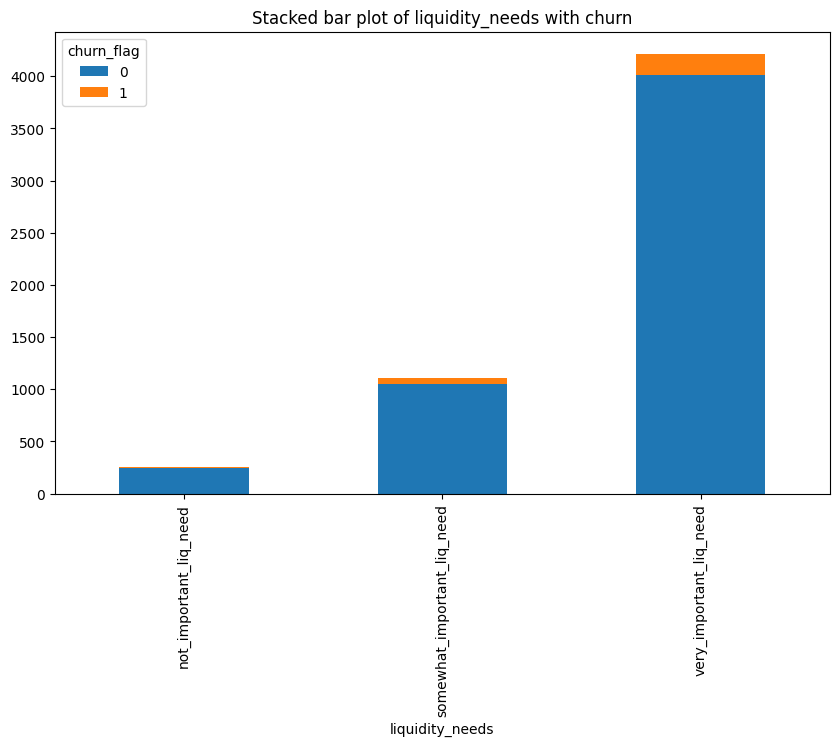

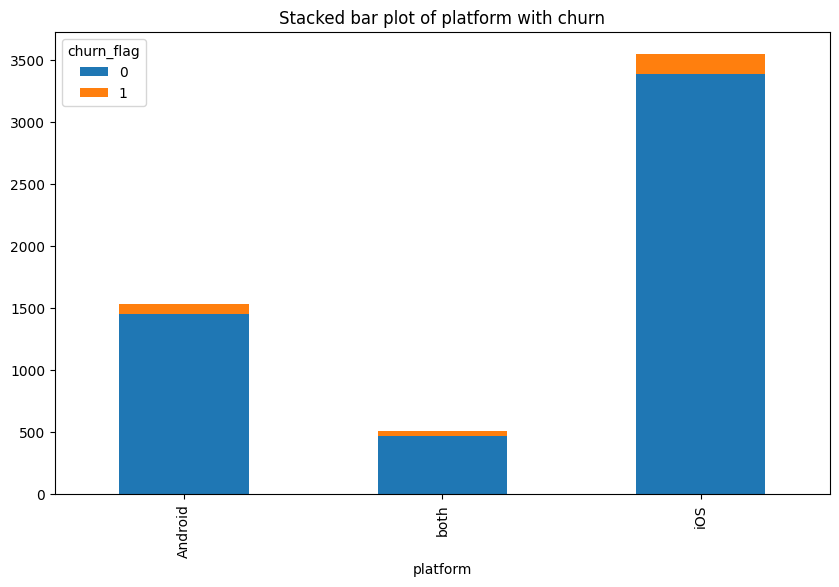

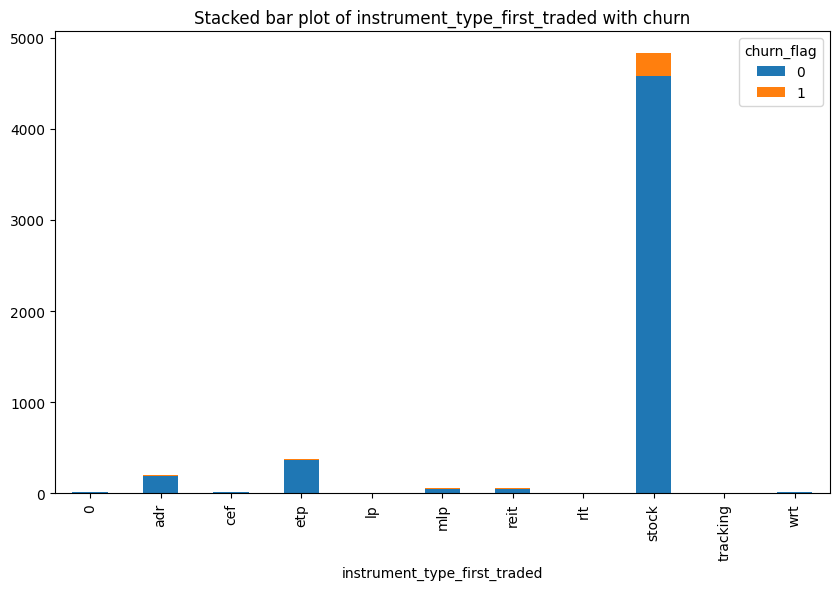

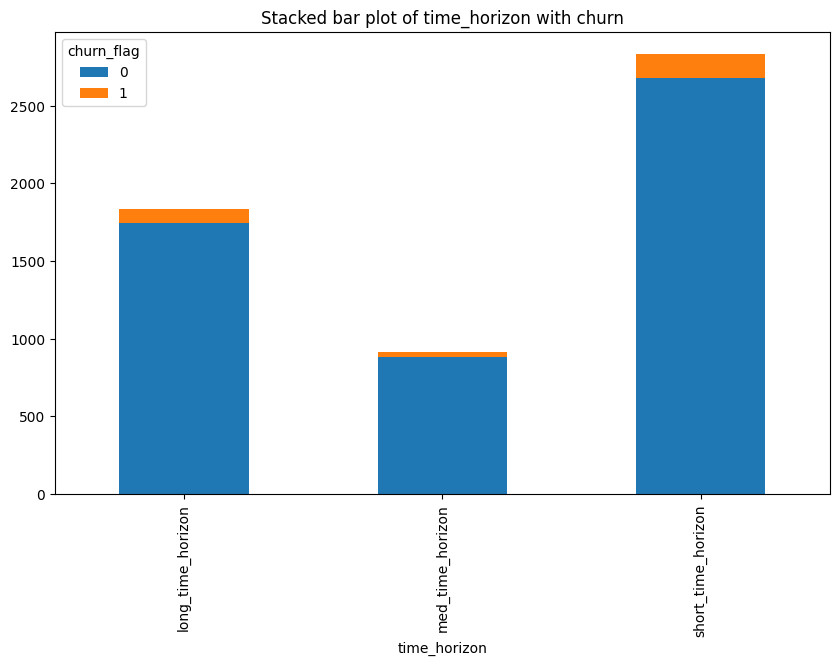

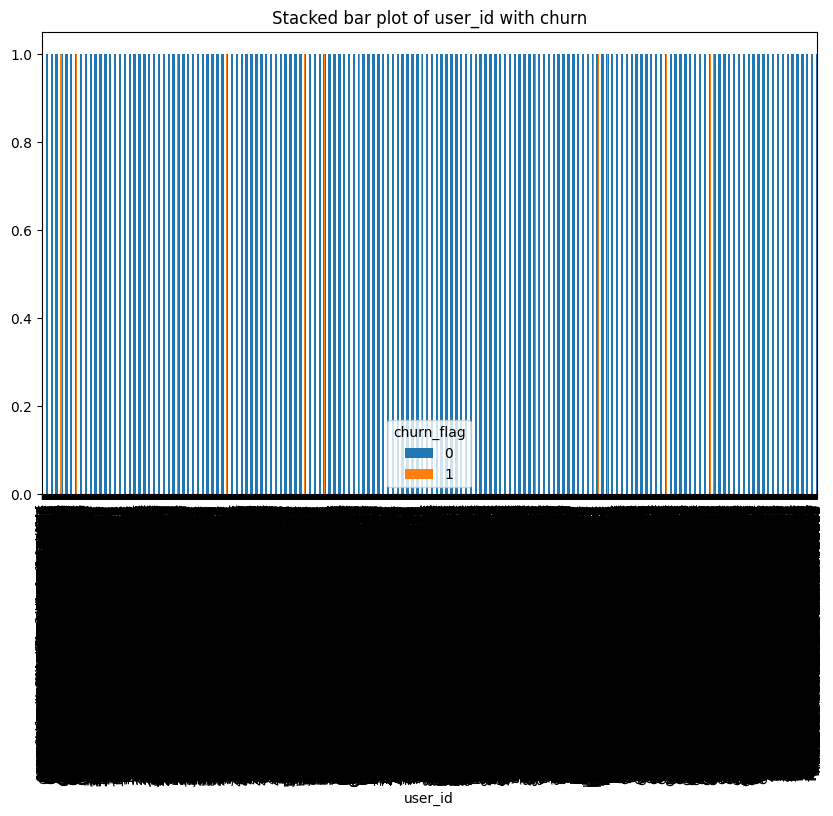

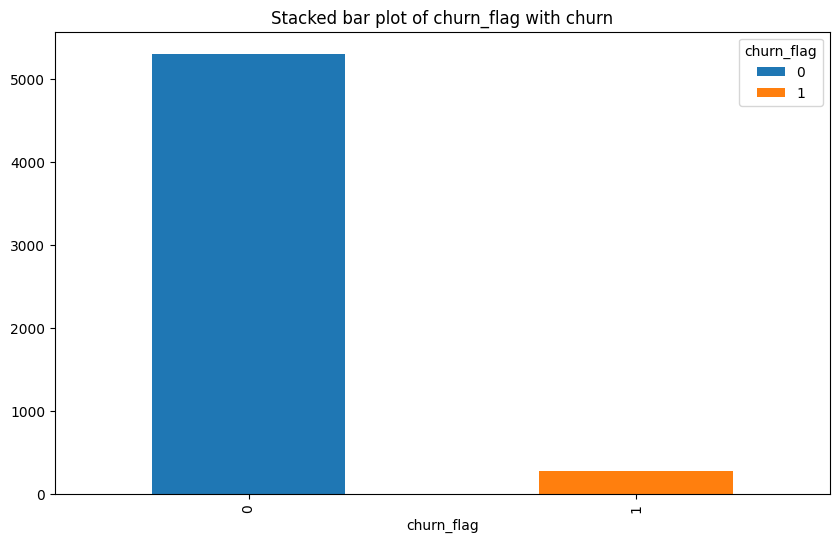

In [318]:
# Bar plots and stacked bar charts to visualize relationships between churn and categorical features.
# Stacked bar plots for churn and categorical variables
for col in cat_cols:
    pd.crosstab(df[col], df['churn_flag']).plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f'Stacked bar plot of {col} with churn')
    plt.show()


### Variance, Standard Deviation, and Spread of numerical variables

In [319]:
# Variance and Standard Deviation of numerical columns
# NEVER TAKE A SD/VARIANCE ON A SD/VARAINCE COLUMN ALREADY.
df[num_cols].var()
df[num_cols].std()
# See Box plot to visualize spread (already covered in previous sections)


time_spent                         155.080551
first_deposit_amount              2118.323263
deposit_per_time                   998.089605
equity_volatility                 4099.645192
avg_rolling_5day_avg             11101.375105
sd_rolling_5day_avg               4650.720795
avg_rolling_5day_sum             55506.875525
sd_rolling_5day_sum              23253.603974
avg_equity_growth_rate               0.248746
equity_volatility_growth_rate        2.243949
total_active_days                   68.906396
avg_equity                       11265.546691
equity_delta_start_to_end        11221.127198
ndays_from_2017_08_18               50.788746
max_streak_duration                  0.252171
dtype: float64

### Identifying Outliers using Z-Scores on numerical variables

In [22]:
# Z-scores for outlier detection
z_scores = np.abs(stats.zscore(df[num_cols]))
outliers = (z_scores > 3).sum(axis=0)  # Count the number of outliers for each column
print(f'Number of outliers per column: {outliers}')


Number of outliers per column: time_spent              31
first_deposit_amount    62
dtype: int64


C:\Users\cheng\AppData\Local\Temp\ipykernel_16692\3188113231.py:2: DeprecationWarning: Please import `zscore` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  z_scores = np.abs(stats.zscore(df[num_cols]))


### Multicollinearity

In [23]:
# Calculate VIF for each numerical column
# Variance Inflation Factor (VIF) checks for multicollinearity between numerical variables:
vif_data = pd.DataFrame()
vif_data['Feature'] = num_cols
vif_data['VIF'] = [variance_inflation_factor(df[num_cols].values, i) for i in range(len(num_cols))]

print(vif_data)


                Feature       VIF
0            time_spent  1.003801
1  first_deposit_amount  1.003801
